<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Data Cleaning: missing values, wrong values, outliers

In [1]:
#install pycountry
!pip install pycountry

#import library
import pandas as pd
import math
import numpy as np
import pycountry 
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
import seaborn as sn

### Function

In [2]:
def detecting_outliers(attr):
    q1 = attr.quantile(0.25)
    q3 = attr.quantile(0.75)
    iqr = q3 - q1
    L = q1 - 1.5*iqr
    R = q3 + 1.5*iqr
    return L, R

In [3]:
def detecting_outliers_numerical(df, attr, L, R, substitute):
  
    df_outliers = df[(df[attr]< L) | (df[attr] > R)]
    new_df = df.drop(df_outliers.index)

    if substitute == 'median':
        median = df[attr].median()
        print("facciamo la mediana", median)
        df_outliers.loc[(df_outliers[attr] < L), attr] = median 
        df_outliers.loc[(df_outliers[attr] > R), attr] = median
    else:
        df_outliers.loc[(df_outliers[attr] < L), attr] = L
        df_outliers.loc[(df_outliers[attr] > R), attr] = R
    
    new_df.append(df_outliers)
    
    return new_df 

# Missing values

Explore the dataset by studying the data quality, their distribution among several different features and the correlations.

In [4]:
df = pd.read_csv('dataset/matches_understanding.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
#pd.options.mode.chained_assignment = None # to avoid the warnings

# some auxiliary functions
def print_stat(df, s):
    print( s+" null_values:\t"+str(df[s].isnull().sum()))
    print( df[s].describe() )

def print_simple_stat(df, s):
    print( s+" null_values:\t"+str(df[s].isnull().sum()))

#attr:
#df: dataframe
#gb_attr: groupby attribute
#nan_attr: attribute to fill nan
#metric: metric to use (mean, median...)
def _fillna_(df, gb_attr, nan_attr, metric):
    tmp_df = df[[gb_attr, nan_attr]]
    print_stat(tmp_df, nan_attr)
    tmp_df[nan_attr].fillna(tmp_df.groupby(gb_attr)[nan_attr].transform(metric), inplace = True)
    tmp_df.loc[nan_attr] = round(tmp_df[nan_attr], 0)
    print_stat(tmp_df, nan_attr)
    return tmp_df

# Accessing and Improving Data Quality: Handling Missing Values

Along the previous phases of Data Detection we have encountered several times the fact that there are missing values, for instance through the isnull() pandas function. For some of them we have also shown their amount. We go on now by trying to find a way thanks to which we can justify why we decide to consider a new value as valid or the deletion of it.

## Discovering and deleting twin rows
The first analysis we are interested in is if we find some rows that are duplicates of others but have more null values while the not null values are in common. For this reason we can delete the rows that result less complete than their twins.

In [5]:
'''
print_simple_stat(df, 'tourney_id') #55
print_simple_stat(df, 'tourney_name') #25
print_simple_stat(df, 'tourney_level') #29
print_simple_stat(df, 'tourney_spectators') #27
print_simple_stat(df, 'tourney_revenue') #26
'''
# FIRST ATTEMPT: by putting in relation tourney_id and tourney_name, both having null values, we get several rows. 
# For this reason we have to be more precise in checking which null values to put simoultaneously
#df[ df.tourney_id.isnull() & df.tourney_name.isnull() ] 

# SECOND ATTEMPT: is found a single row with index 186075. To achieve it we have proven with several attempts seeing which could reduce our range of results.
df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.tourney_date.isnull() 
   & df.winner_name.isnull() & df.loser_name.isnull()]
#print( df.loc[186075] )


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_gender,loser_gender
186075,NaN,NaN,NaN,32.0,NaN,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NED,26.0,203567.0,NaN,NaN,R,NaN,NaN,21.0,7-6(4) 7-5,3.0,NaN,NaN,NaN,NaN,NaN,44.0,29.0,12.0,NaN,3.0,NaN,7.0,3.0,79.0,NaN,32.0,NaN,NaN,1.0,5.0,NaN,NaN,194.0,NaN,NaN,NaN,U,U


In [6]:
# THIRD ATTEMPT: we search for other rows that have as not null values those of the row just identified 
# by detecting some values is useless since they can be the same for a lot of data such as for instance the draw_size=32 or loser_hand='R' which don't allow us to detect something else 
# depending from their values
# but also for values that could be more unique as match_num=272, loser_id=203567.0 we identify several combinations of different attributes that cannot help
#df[ df.loser_age==21.57974 ] #it does not find any row, neither the 186075
#df[ (df.winner_ioc=='NED') | (df.winner_age==26.918549) ] #it is not a good combination since it finds a lot of rows

df[ (df.loser_rank==194.0) & (df.loser_id==203567.0) ] #it is a good combination of attributes since it finds a unique row, that identified by 12025
# we note that the first checked row 186075 has in common with the 12025 row all its non null values and some NaN values too, but for us are important those that are not NaN that have to match
# since 12025 is more complete than the other we can decide to drop it out
#print( df.loc[12025] )

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_gender,loser_gender
12025,2017-1059,Taipei,Hard,32.0,C,2017-11-13,272.0,201551.0,NaN,Arantxa Rus,L,180.0,NED,26.0,203567.0,NaN,Ipek Soylu,R,NaN,TUR,21.0,7-6(4) 7-5,3.0,R32,101.0,1.0,4.0,66.0,44.0,29.0,12.0,12.0,3.0,6.0,7.0,3.0,79.0,54.0,32.0,11.0,12.0,1.0,5.0,167.0,353.0,194.0,299.0,3535.0,638954.72,F,F
186075,NaN,NaN,NaN,32.0,NaN,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NED,26.0,203567.0,NaN,NaN,R,NaN,NaN,21.0,7-6(4) 7-5,3.0,NaN,NaN,NaN,NaN,NaN,44.0,29.0,12.0,NaN,3.0,NaN,7.0,3.0,79.0,NaN,32.0,NaN,NaN,1.0,5.0,NaN,NaN,194.0,NaN,NaN,NaN,U,U


In [7]:
#drop row with more NaN values
df = df.drop(index=186075) 

In [8]:
"""
print_simple_stat(df, 'tourney_id') #54
print_simple_stat(df, 'tourney_name') #24
print_simple_stat(df, 'tourney_level') #28
print_simple_stat(df, 'tourney_spectators') #26
print_simple_stat(df, 'tourney_revenue') #25

# found a single row with this combination of null attributes, 186077
df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.tourney_date.isnull() ] 
df[ (df.winner_name=='Magdalena Frech') & (df.winner_rank==172.0) ] #12027
"""
df = df.drop(index=186077) # again we drop the one that is less complete
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #53
print_simple_stat(df, 'tourney_name') #23
print_simple_stat(df, 'tourney_level') #27
print_simple_stat(df, 'tourney_spectators') #25
print_simple_stat(df, 'tourney_revenue') #24

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() & df.l_bpSaved.isnull() ] #186104
df[ (df.loser_name=='Carol Zhao') & (df.loser_rank==150.0) ] #12054
"""
df = df.drop(index=186104)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #52
print_simple_stat(df, 'tourney_name') #22
print_simple_stat(df, 'tourney_level') #26
print_simple_stat(df, 'tourney_spectators') #24
print_simple_stat(df, 'tourney_revenue') #23

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_date.isnull()] #186096
df[ (df.loser_id==214544.0) & (df.loser_name=='Aryna Sabalenka') & (df['round']=='R16') & (df.w_df==1.0)]  #12046
"""
df = df.drop(index=186096)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #51
print_simple_stat(df, 'tourney_name') #21
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #24
print_simple_stat(df, 'tourney_revenue') #23

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() &df.match_num.isnull() & df.winner_hand.isnull()] #186125
df[ (df.loser_id==201674.0) & (df.loser_ioc=='UZB') & (df.tourney_level=='C') & (df.winner_name=='Dalila Jakupovic')] #12063
"""
df = df.drop(index=186125)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #50
print_simple_stat(df, 'tourney_name') #20
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #22

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() &df.match_num.isnull() ]#186121
df[ (df.loser_name=='Vivian Heisen') & (df.loser_ioc=='GER') & (df.tourney_level=='C') & (df.winner_hand=='R') & (df.w_df==3.0)] #12059
"""
df = df.drop(index=186121)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #49
print_simple_stat(df, 'tourney_name') #19
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #22

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_date.isnull() & df.loser_id.isnull() ] #186082
df[ (df.winner_name=='Sabina Sharipova') & (df.winner_ioc=='UZB') & (df.tourney_level=='C') & (df.match_num==246.0) ] #12057
"""
df = df.drop(index=186082)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #48
print_simple_stat(df, 'tourney_name') #18
print_simple_stat(df, 'tourney_level') #25
print_simple_stat(df, 'tourney_spectators') #23
print_simple_stat(df, 'tourney_revenue') #21

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.tourney_level.isnull() & df.tourney_spectators.isnull() ] #186108
df[ (df.tourney_date=='2017-11-13') & (df.loser_ioc=='KOR') & (df['round']=='Q1') & (df.minutes==91.0) ] #12058
"""
df = df.drop(index=186108)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #47
print_simple_stat(df, 'tourney_name') #17
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #20

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.winner_name.isnull() ]#186091
df[ (df.tourney_date=='2017-11-13') & (df.winner_hand=='R') & (df.tourney_level=='C') & (df.match_num==288.00) & (df.winner_ht==175.00)] #12041
"""
df = df.drop(index=186091)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #46
print_simple_stat(df, 'tourney_name') #16
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.draw_size.isnull() ]#186119
df[ (df.tourney_level=='C') & (df.match_num==246.00) & (df.winner_name=='Sabina Sharipova') ]#12057 and 186107
"""
df = df.drop(index=186119)
df = df.drop(index=186107)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #44
print_simple_stat(df, 'tourney_name') #15
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #22
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() & df.winner_ht.isnull() ]#186122
df[ (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Priscilla Hon') ]#186122 -> 12060 and 186127 -> 12065
"""
df = df.drop(index=186122)
df = df.drop(index=186127)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #42
print_simple_stat(df, 'tourney_name') #14
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #21
print_simple_stat(df, 'tourney_revenue') #19

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.surface.isnull() ]#186126
df[ (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Vitalia Diatchenko') ]#12064
"""
df = df.drop(index=186126)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #41
print_simple_stat(df, 'tourney_name') #13
print_simple_stat(df, 'tourney_level') #24
print_simple_stat(df, 'tourney_spectators') #21
print_simple_stat(df, 'tourney_revenue') #18

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.loser_name.isnull() ]#186123
df[ (df.draw_size==32.00) & (df.tourney_date=='2017-11-13') & (df.match_num==250.00) & (df.surface=='Hard') & (df.loser_id==206075.00)]#12061
"""
df = df.drop(index=186123)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #40
print_simple_stat(df, 'tourney_name') #12
print_simple_stat(df, 'tourney_level') #23
print_simple_stat(df, 'tourney_spectators') #20
print_simple_stat(df, 'tourney_revenue') #17

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.winner_hand.isnull() ]#186081
df[ (df.draw_size==32.00) & (df.tourney_date=='2017-11-13') & (df.surface=='Hard') & (df.winner_ioc=='JPN') & (df.loser_name=='Dalila Jakupovic')]#12031
"""
df = df.drop(index=186081)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #39
print_simple_stat(df, 'tourney_name') #11
print_simple_stat(df, 'tourney_level') #22
print_simple_stat(df, 'tourney_spectators') #19
print_simple_stat(df, 'tourney_revenue') #17

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() & df.match_num.isnull() ]#186120
df[ (df.surface=='Hard') & (df.winner_hand=='R') & (df.minutes==91.00) & (df.winner_rank==230.00)] #12058
"""
df = df.drop(index=186120)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #38
print_simple_stat(df, 'tourney_name') #10
print_simple_stat(df, 'tourney_level') #21
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #16

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.winner_name.isnull() ]#186079
df[ (df.surface=='Hard') & (df.match_num==276.00) & (df.winner_hand=='R') & (df.winner_ht==189.00)] #12029
"""
df = df.drop(index=186079)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #37
print_simple_stat(df, 'tourney_name') #9
print_simple_stat(df, 'tourney_level') #20
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #16

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.score.isnull() ]#186087
df[ (df.surface=='Hard') & (df.draw_size==32.00) & (df.winner_name=='Viktorija Golubic') & (df.loser_id==202693.00)] #12037
"""
df = df.drop(index=186087)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #36
print_simple_stat(df, 'tourney_name') #8
print_simple_stat(df, 'tourney_level') #19
print_simple_stat(df, 'tourney_spectators') #18
print_simple_stat(df, 'tourney_revenue') #15

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.minutes.isnull() ]#186102
df[ (df.surface=='Hard') & (df.winner_name=='Belinda Bencic') & (df.winner_entry=='WC') & (df.w_1stIn==38.00) ] #12052
"""
df = df.drop(index=186102)

"""
#when discovered raw 12052, without the last condition, we saw that also 186094 has so much null values
df[ (df.surface=='Hard') & (df.winner_name=='Belinda Bencic') & (df.match_num==291.00) ] #12044
"""
df = df.drop(index=186094)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #34
print_simple_stat(df, 'tourney_name') #7
print_simple_stat(df, 'tourney_level') #17
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() & df.draw_size.isnull() ]#186085
df[ (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Luksika Kumkhum') & (df.loser_name=='Ana Bogdan')]#12052
"""
df = df.drop(index=186085)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #33
print_simple_stat(df, 'tourney_name') #6
print_simple_stat(df, 'tourney_level') #16
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.tourney_level.isnull() ]#186109
df[ (df.surface=='Hard') & (df.draw_size==32.00) & (df.match_num==248.00) & (df.winner_name=='Vitalia Diatchenko')] #12052
"""
df = df.drop(index=186109)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #32
print_simple_stat(df, 'tourney_name') #5
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.draw_size.isnull() ]#186086
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.winner_name=='Marie Bouzkova') & (df.loser_id==201667.0) ] #12036
"""
df = df.drop(index=186086)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #31
print_simple_stat(df, 'tourney_name') #4
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.winner_ioc.isnull() ]#186076
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_id==201518.00) ] #12026
"""
df = df.drop(index=186076)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #30
print_simple_stat(df, 'tourney_name') #3
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #14

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.match_num.isnull() ]#186101
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='NED') & (df.loser_id==201648.00)] #12051
"""
df = df.drop(index=186101)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #29
print_simple_stat(df, 'tourney_name') #2
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #17
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.tourney_name.isnull() & df.winner_hand.isnull() ]#186080
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='KOR') & (df.match_num==277.00) & (df.loser_ioc=='RUS')] #12030
"""
df = df.drop(index=186080)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #28
print_simple_stat(df, 'tourney_name') #1
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.tourney_name.isnull() ]#186106
df[ (df.surface=='Hard') & (df.tourney_level=='C') & (df.draw_size==32.00) & (df.winner_ioc=='SLO') & (df.match_num==245.00) & (df.loser_ioc=='MEX')] #12056
"""
df = df.drop(index=186106)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #27
print_simple_stat(df, 'tourney_name') #0 STOP
print_simple_stat(df, 'tourney_level') #15
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186078, 186092, 186095, 186099, 186113 ... 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_entry=='Q') & (df.match_num==275.00) ]#12028
"""
df = df.drop(index=186078)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #26
print_simple_stat(df, 'tourney_level') #14
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186095, 186099, 186113 ... 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_entry=='WC') & (df.loser_id==203475.00) ]#12054
"""
df = df.drop(index=186116)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #25
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_id==213631.00) ]#12045
"""
df = df.drop(index=186095)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #24
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #16
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115 186118]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.loser_name=='Victoria Rodriguez') ]#12056
"""
df = df.drop(index=186118)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #23
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #15
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #11

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113 ... 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_level=='C') & (df.match_num==253.00) & (df.winner_ioc=='RUS') ]#12064
"""
df = df.drop(index=186114)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #22
print_simple_stat(df, 'tourney_level') #13
print_simple_stat(df, 'tourney_spectators') #15
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186099, 186113, 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.match_num==296.00) & (df.winner_ioc=='SUI') ]#12049
"""
df = df.drop(index=186099)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #21
print_simple_stat(df, 'tourney_level') #12
print_simple_stat(df, 'tourney_spectators') #14
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186113, 186115]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.minutes==70.00) & (df.loser_rank==196.00) ]#12063
"""
df = df.drop(index=186113)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #20
print_simple_stat(df, 'tourney_level') #11
print_simple_stat(df, 'tourney_spectators') #13
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#[186092, 186115]
df[ (df.tourney_name=='Taipei') & (df.match_num==289.00) & (df.winner_name=='Naomi Broady') ]#12042
"""
df = df.drop(index=186092)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #20
print_simple_stat(df, 'tourney_level') #11
print_simple_stat(df, 'tourney_spectators') #13
print_simple_stat(df, 'tourney_revenue') #13
print_simple_stat(df, 'tourney_date') #10

df[ df.tourney_id.isnull() & df.surface.isnull() & df.draw_size.isnull()]#186115
df[ (df.tourney_name=='Taipei') & (df.loser_id==202614.00) & (df.winner_name=='Priscilla Hon') ]#12065
"""
df = df.drop(index=186115)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #18
print_simple_stat(df, 'tourney_level') #9
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #12
print_simple_stat(df, 'tourney_date') #8

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_level.isnull()] #[186083, 186112]
df[ (df.tourney_name=='Taipei') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Priscilla Hon') & (df.winner_entry=='Q') ]#12033
"""
df = df.drop(index=186083)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #17
print_simple_stat(df, 'tourney_level') #8
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #11
print_simple_stat(df, 'tourney_date') #8

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_level.isnull()] #186112
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.winner_name=='Veronika Kudermetova') & (df.match_num==251.00) ]#12062
"""
df = df.drop(index=186112)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #16
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #12
print_simple_stat(df, 'tourney_revenue') #10
print_simple_stat(df, 'tourney_date') #7

df[ df.tourney_id.isnull() & df.surface.isnull() & df.tourney_date.isnull()] #186117
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.loser_id==203576.00) ]#12055, also 186105 satisfies it
"""
df = df.drop(index=186117)
df = df.drop(index=186105)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #14
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #10
print_simple_stat(df, 'tourney_revenue') #8
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.surface.isnull() & df.winner_name.isnull()] #186084
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.loser_name=='Ying Ying Duan') ]#12034
"""
df = df.drop(index=186084)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #13
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #10
print_simple_stat(df, 'tourney_revenue') #7
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.surface.isnull() ]#186124
df[ (df.tourney_name=='Taipei') & (df.draw_size==32.00) & (df.tourney_level=='C') & (df.winner_name=='Veronika Kudermetova') & (df.loser_id==214562.00)]#12062
"""
df = df.drop(index=186124)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #12
print_simple_stat(df, 'tourney_level') #7
print_simple_stat(df, 'tourney_spectators') #9
print_simple_stat(df, 'tourney_revenue') #6
print_simple_stat(df, 'tourney_date') #6

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() & df.tourney_date.isnull()]#186110
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.loser_entry=='WC') & (df['round']=='Q1') & (df.winner_rank==231.00)]#12062
"""
df = df.drop(index=186110)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #11
print_simple_stat(df, 'tourney_level') #6
print_simple_stat(df, 'tourney_spectators') #8
print_simple_stat(df, 'tourney_revenue') #5
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() & df.winner_ioc.isnull()]#186103
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.match_num==300.00)]#12053
"""
df = df.drop(index=186103)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #10
print_simple_stat(df, 'tourney_level') #5
print_simple_stat(df, 'tourney_spectators') #7
print_simple_stat(df, 'tourney_revenue') #4
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_level.isnull() ]#186090
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_date=='2017-11-13') & (df.match_num==287.00)]#12040
"""
df = df.drop(index=186090)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #9
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #6
print_simple_stat(df, 'tourney_revenue') #4
print_simple_stat(df, 'tourney_date') #5

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.tourney_date.isnull() ]#186093
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.match_num==290.00) & (df.loser_id==203552.00)]#12043
"""
df = df.drop(index=186093)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #8
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #3
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.draw_size.isnull() & df.winner_hand.isnull() ]#186111
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.match_num==250.00) & (df.winner_name=='Jacqueline Cako')]#12061
"""
df = df.drop(index=186111)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #7
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #2
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.draw_size.isnull() ]#186100
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.winner_name=='Viktorija Golubic') & (df.loser_id==202503.00)]#12050
"""
df = df.drop(index=186100)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #6
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #5
print_simple_stat(df, 'tourney_revenue') #2
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() & df.loser_id.isnull()]#186074
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.tourney_level=='C') & (df.tourney_date=='2017-11-13') & (df.match_num==271.00) & (df.loser_name=='Sara Errani')]#120524
"""
df = df.drop(index=186074)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #5
print_simple_stat(df, 'tourney_level') #4
print_simple_stat(df, 'tourney_spectators') #4
print_simple_stat(df, 'tourney_revenue') #1
print_simple_stat(df, 'tourney_date') #4

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() & df.winner_name.isnull()]#186089
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.match_num==286.00) & (df.loser_id==205815.00)]#120524
"""
df = df.drop(index=186089)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #4
print_simple_stat(df, 'tourney_level') #3
print_simple_stat(df, 'tourney_spectators') #3
print_simple_stat(df, 'tourney_revenue') #1
print_simple_stat(df, 'tourney_date') #3

df[ df.tourney_id.isnull() & df.winner_ioc.isnull() ]#186098
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.match_num==295.00) & (df.loser_id==206368.00)]#12048
"""
df = df.drop(index=186098)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #3
print_simple_stat(df, 'tourney_level') #2
print_simple_stat(df, 'tourney_spectators') #2
print_simple_stat(df, 'tourney_revenue') #0 STOP
print_simple_stat(df, 'tourney_date') #2

df[ df.tourney_id.isnull() & df.match_num.isnull() ]#186097
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.winner_ioc=='NED') & (df.loser_id==211878.00)]#12047
"""
df = df.drop(index=186097)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #2
print_simple_stat(df, 'tourney_level') #1
print_simple_stat(df, 'tourney_spectators') #1
print_simple_stat(df, 'tourney_date') #1

df[ df.tourney_id.isnull() & df.tourney_level.isnull() ]#186073
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.tourney_date=='2017-11-13') & (df.match_num==270.00)]#12023
"""
df = df.drop(index=186073)
#--------------------------------------------------------------------------------------------------
"""
print_simple_stat(df, 'tourney_id') #1
print_simple_stat(df, 'tourney_level') #0 STOP
print_simple_stat(df, 'tourney_spectators') #1
print_simple_stat(df, 'tourney_date') #1

df[ df.tourney_id.isnull() ]#186088
df[ (df.tourney_name=='Taipei') & (df.surface=='Hard') & (df.draw_size==32.00)  & (df.tourney_level=='C') & (df.match_num==285.00) & (df.winner_ioc=='BLR')]#12038
"""
df = df.drop(index=186088)
#--------------------------------------------------------------------------------------------------

#### Stats on missing values
Some missing values are resolved removing twin rows. In particular for some attributes there are no one missing values while for attributes reguarding statistics of matches as aces, number of services and breakpoints they are the same missing values.

In [9]:
#the results of NaN values, first and after twin rows deletion, are left commented  
print_simple_stat(df, 'tourney_id') #0 STOP
print_simple_stat(df, 'tourney_spectators') #0 STOP
print_simple_stat(df, 'tourney_date') #0 STOP

#Matches
print_simple_stat(df, 'match_num') #27 --> 0 STOP
print_simple_stat(df, 'draw_size') #29 --> 0 STOP
print_simple_stat(df, 'round') #30 --> 0 STOP
print_simple_stat(df, 'best_of') #29 --> 0 STOP

print_simple_stat(df, 'surface') #188 --> 162
print_simple_stat(df, 'minutes') #104468 --> 104430
print_simple_stat(df, 'score') #199 --> 169

# with the ones remained different from 0 we cannot discover single rows like we did till now, 
# for this we have to consider also the attributes of the Players group

#Players
print_simple_stat(df, 'winner_id') #55 --> 0 STOP
print_simple_stat(df, 'loser_id') #28 --> 0 STOP
print_simple_stat(df, 'winner_name') #27 --> 0 STOP
print_simple_stat(df, 'loser_name') #31 --> 0 STOP
print_simple_stat(df, 'winner_ioc') #29 --> 0 STOP
print_simple_stat(df, 'loser_ioc') #26  --> 0 STOP

print_simple_stat(df, 'winner_ht') #136787 --> 136474
print_simple_stat(df, 'loser_ht') #147780 --> 147438
print_simple_stat(df, 'winner_age') #2853 --> 2828
print_simple_stat(df, 'loser_age') #6538 --> 6501
print_simple_stat(df, 'winner_hand') # 46 --> 16
print_simple_stat(df, 'loser_hand') #98 --> 71
print_simple_stat(df, 'winner_gender') #2704 --> 2677
print_simple_stat(df, 'loser_gender') #2129 --> 2098
print_simple_stat(df, 'winner_entry') #160301 --> 159958
print_simple_stat(df, 'loser_entry') #141974 --> 141684
print_simple_stat(df, 'winner_rank') #19409 --> 19372
print_simple_stat(df, 'loser_rank') #35283 --> 35232
print_simple_stat(df, 'winner_rank_points') #19427 --> 19388
print_simple_stat(df, 'loser_rank_points') #35300 --> 35248

# while the following have achieved the same values of --> 103782

print_simple_stat(df, 'w_ace') #103818
print_simple_stat(df, 'l_ace') #103815 
print_simple_stat(df, 'w_df') #103816
print_simple_stat(df, 'l_df') #103809 
print_simple_stat(df, 'w_svpt') #103818
print_simple_stat(df, 'l_svpt') #103813 
print_simple_stat(df, 'w_1stIn') #103818
print_simple_stat(df, 'l_1stIn') #103824 
print_simple_stat(df, 'w_1stWon') #103816
print_simple_stat(df, 'l_1stWon') #103817
print_simple_stat(df, 'w_2ndWon') #103819
print_simple_stat(df, 'l_2ndWon') #103816 
print_simple_stat(df, 'w_SvGms') #103817
print_simple_stat(df, 'l_SvGms') #103810 
print_simple_stat(df, 'w_bpSaved') #103813
print_simple_stat(df, 'l_bpSaved') #103817 
print_simple_stat(df, 'w_bpFaced') #103816
print_simple_stat(df, 'l_bpFaced') #103822 

tourney_id null_values:	0
tourney_spectators null_values:	0
tourney_date null_values:	0
match_num null_values:	0
draw_size null_values:	0
round null_values:	0
best_of null_values:	0
surface null_values:	162
minutes null_values:	104430
score null_values:	169
winner_id null_values:	0
loser_id null_values:	0
winner_name null_values:	0
loser_name null_values:	0
winner_ioc null_values:	0
loser_ioc null_values:	0
winner_ht null_values:	136474
loser_ht null_values:	147438
winner_age null_values:	2828
loser_age null_values:	6501
winner_hand null_values:	16
loser_hand null_values:	71
winner_gender null_values:	0
loser_gender null_values:	0
winner_entry null_values:	159958
loser_entry null_values:	141684
winner_rank null_values:	19372
loser_rank null_values:	35232
winner_rank_points null_values:	19388
loser_rank_points null_values:	35248
w_ace null_values:	103782
l_ace null_values:	103782
w_df null_values:	103782
l_df null_values:	103782
w_svpt null_values:	103782
l_svpt null_values:	103782
w_1s

###### Notice that the following attributes not only have the same amount of NaN but also all missing values are present in the same rows.

In [10]:
dataf = df[df['w_ace'].isna()]
                                     #NaN first removing twin rows
print_simple_stat(dataf, 'w_ace')    #103818
print_simple_stat(dataf, 'l_ace')    #103815 
print_simple_stat(dataf, 'w_df')     #103816
print_simple_stat(dataf, 'l_df')     #103809 
print_simple_stat(dataf, 'w_svpt')   #103818
print_simple_stat(dataf, 'l_svpt')   #103813 
print_simple_stat(dataf, 'w_1stIn')  #103818
print_simple_stat(dataf, 'l_1stIn')  #103824 
print_simple_stat(dataf, 'w_1stWon') #103816
print_simple_stat(dataf, 'l_1stWon') #103817
print_simple_stat(dataf, 'w_2ndWon') #103819
print_simple_stat(dataf, 'l_2ndWon') #103816 
print_simple_stat(dataf, 'w_SvGms')  #103817
print_simple_stat(dataf, 'l_SvGms')  #103810 
print_simple_stat(dataf, 'w_bpSaved')#103813
print_simple_stat(dataf, 'l_bpSaved')#103817 
print_simple_stat(dataf, 'w_bpFaced')#103816
print_simple_stat(dataf, 'l_bpFaced')#103822 

w_ace null_values:	103782
l_ace null_values:	103782
w_df null_values:	103782
l_df null_values:	103782
w_svpt null_values:	103782
l_svpt null_values:	103782
w_1stIn null_values:	103782
l_1stIn null_values:	103782
w_1stWon null_values:	103782
l_1stWon null_values:	103782
w_2ndWon null_values:	103782
l_2ndWon null_values:	103782
w_SvGms null_values:	103778
l_SvGms null_values:	103778
w_bpSaved null_values:	103782
l_bpSaved null_values:	103782
w_bpFaced null_values:	103782
l_bpFaced null_values:	103782


#### w_SvGms and l_SvGms
First attempt was with interpolation that is commented now since there is a more efficient solution to resolve missing values of SvGms: in a tennis match, players alternate the service, so a player serves about an half of sets. Summing score, the total number of sets played are obtained. Also a new attribute SvGms are created and deletes w_SvGms and l_SvGms because they are strongly correletad.

In [11]:
#FIRST ATTEMPT: RESOLVE NaN WITH INTERPOLATION                        NaN
#print_simple_stat(df, 'w_SvGms')                                 #103817
#print_simple_stat(df, 'l_SvGms')                                 #103810 
#df_SvGms_linear = df[['w_SvGms', 'l_SvGms']]
#print(df_SvGms_linear.describe())

#df_SvGms_linear = df_SvGms_linear.interpolate(method='linear')
#print_simple_stat(df_SvGms_linear, 'w_SvGms')                         #0
#print_simple_stat(df_SvGms_linear, 'l_SvGms')                         #0
#print(df_SvGms_linear.describe())

#df_SvGms_polynomial = df[['w_SvGms', 'l_SvGms']].interpolate(method='polynomial', order=2)
#print_simple_stat(df_SvGms_polynomial, 'w_SvGms') 
#print_simple_stat(df_SvGms_polynomial, 'l_SvGms') 
#print(df_SvGms_polynomial.describe())

# the linear interpolation does the most working fitting
#df[['w_SvGms', 'l_SvGms']] = df_SvGms_linear

In [12]:
#find the number of sets played in each match
score = df.score.replace( {'[(]\d[)]' : '',
                           '[(]\d\d[)]' : '',
                           '\[.' : '',
                           '-' : ' ',
                           '[&a-zA-z\/,;]' : '',
                          }, 
                         regex = True)
score.dropna(inplace = True)
score = score.apply(lambda x: [int(word) for word in x.split() if word.isdigit()])
score = score.apply(lambda x: sum(x))
score = pd.DataFrame(score)
score.set_axis(['SvGms'], axis = 1, inplace = True)
#create the new attribute SvGms and delete w_SvGms and l_SvGms
df = pd.merge(df, score, how = 'left', left_index=True, right_index=True)
del df['w_SvGms']
del df['l_SvGms']

### w_svpt w_1stIn and  l_svpt l_1stIn
Try to discover values of svpt and 1stIn using interpolation with SvGms

In [13]:
#we try different methods of interpolation: linear and polynomial
#let's see the distribution before interpolation
print_simple_stat(df, 'w_svpt') #103818
print_simple_stat(df, 'w_1stIn') #103818
#print_simple_stat(df, 'w_1stWon') #103816
df_linear = df[['w_svpt', 'w_1stIn', 'SvGms']]
print(df_linear.describe())

#interpolate and see how change distribution
df_linear = df_linear.interpolate(method='linear') #linear interpolation
print_simple_stat(df_linear, 'w_svpt') #0
print_simple_stat(df_linear, 'w_1stIn') #0
#print_simple_stat(df_linear, 'w_1stWon') #0
print(df_linear.describe())
df_polynomial = df[['w_svpt', 'w_1stIn', 'SvGms']].interpolate(method='polynomial', order=2) #polynomial
print_simple_stat(df_polynomial, 'w_svpt') 
print_simple_stat(df_polynomial, 'w_1stIn') 
#print_simple_stat(df_polynomial, 'w_1stWon') 
print(df_polynomial.describe())
print_simple_stat(df, 'l_svpt') #103813 
print_simple_stat(df, 'l_1stIn') #103824 
#print_simple_stat(df, 'l_1stWon') #103817
df_linear2 = df[['l_svpt', 'l_1stIn', 'SvGms']]
print(df_linear2.describe())
df_linear2 = df_linear2.interpolate(method='linear')
print_simple_stat(df_linear2, 'l_svpt') #0
print_simple_stat(df_linear2, 'l_1stIn') #0
#print_simple_stat(df_linear2, 'l_1stWon') #0
print(df_linear2.describe())
df_polynomial2 = df[['l_svpt', 'l_1stIn', 'SvGms']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial2, 'l_svpt') 
print_simple_stat(df_polynomial2, 'l_1stIn') 
#print_simple_stat(df_polynomial2, 'l_1stWon') 
print(df_polynomial.describe())

# the linear interpolation does the most working fitting
df[['w_svpt', 'w_1stIn', 'SvGms']] = df_linear
df[['l_svpt', 'l_1stIn', 'SvGms']] = df_linear2 

#take only integer part
df[['w_svpt', 'w_1stIn']], rest = divmod(df[['w_svpt', 'w_1stIn']], 1)
df[['l_svpt', 'l_1stIn']], rest = divmod(df[['l_svpt', 'l_1stIn']], 1) 

w_svpt null_values:	103782
w_1stIn null_values:	103782
             w_svpt       w_1stIn          SvGms
count  81982.000000  81982.000000  185595.000000
mean      71.297004     44.270901      21.147132
std       25.530921     16.950740       6.797639
min        0.000000      0.000000       0.000000
25%       53.000000     33.000000      16.000000
50%       67.000000     42.000000      20.000000
75%       87.000000     54.000000      26.000000
max     1957.000000   1330.000000      99.000000
w_svpt null_values:	0
w_1stIn null_values:	0
              w_svpt        w_1stIn          SvGms
count  185764.000000  185764.000000  185764.000000
mean       69.561850      45.608977      21.147410
std        21.711929      14.726656       6.795732
min         0.000000       0.000000       0.000000
25%        54.000000      35.000000      16.000000
50%        62.735412      42.000000      20.000000
75%        86.000000      61.000000      26.000000
max      1957.000000    1330.000000      99.000000


### breakpoints 
First attempt: try to handle missing values with interpolation, but because if in a row if one of attr is NaN and also the other is NaN and this solution is not helpful. So breakpoints are resolved grouping by name, missing values are substituted with mean or median according to the more closed standard deviation.    

In [14]:
"""
print_simple_stat(df, 'w_bpSaved') #103813
print_simple_stat(df, 'w_bpFaced') #103816
df_linear = df[['w_bpSaved', 'w_bpFaced']]
print(df_linear.describe())
df_linear = df_linear.interpolate(method='linear')
print_simple_stat(df_linear, 'w_bpSaved') #0
print_simple_stat(df_linear, 'w_bpFaced') #0
print(df_linear.describe())
df_polynomial = df[['w_bpSaved', 'w_bpFaced']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial, 'w_bpSaved') #
print_simple_stat(df_polynomial, 'w_bpFaced') #
print(df_polynomial.describe())

print_simple_stat(df, 'l_bpSaved') #103817
print_simple_stat(df, 'l_bpFaced') #103822 
df_linear2 = df[['l_bpSaved', 'l_bpFaced']]
print(df_linear2.describe())
df_linear2 = df_linear2.interpolate(method='linear')
print_simple_stat(df_linear2, 'l_bpSaved') #0
print_simple_stat(df_linear2, 'l_bpFaced') #0
print(df_linear2.describe())
df_polynomial2 = df[['l_bpSaved', 'l_bpFaced']].interpolate(method='polynomial', order=2)
print_simple_stat(df_polynomial2, 'l_bpSaved') #
print_simple_stat(df_polynomial2, 'l_bpFaced') #
print(df_polynomial2.describe())

# the linear interpolation does the most working fitting
df[['w_bpSaved', 'w_bpFaced']] = df_linear 
df[['l_bpSaved', 'l_bpFaced']] = df_linear2

df[['w_bpSaved', 'w_bpFaced']], rest = divmod(df[['w_bpSaved', 'w_bpFaced']], 1)
df[['l_bpSaved', 'l_bpFaced']], rest = divmod(df[['l_bpSaved', 'l_bpFaced']], 1) 
"""

winner_bpSaved_mean = _fillna_(df, 'winner_name', 'w_bpSaved', 'mean') #
winner_bpSaved_median = _fillna_(df, 'winner_name', 'w_bpSaved', 'median') #
winner_bpFaced_mean = _fillna_(df, 'winner_name', 'w_bpFaced', 'mean') #
winner_bpFaced_median = _fillna_(df, 'winner_name', 'w_bpFaced', 'median') #

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_bpSaved'] = df['w_bpSaved'].fillna(df.groupby('winner_name')['w_bpSaved'].transform('median'))
df['w_bpSaved'] = round(df['w_bpSaved'], 0)
df['w_bpFaced'] = df['w_bpFaced'].fillna(df.groupby('winner_name')['w_bpFaced'].transform('median'))
df['w_bpFaced'] = round(df['w_bpFaced'], 0)

loser_bpSaved_mean =  _fillna_(df, 'loser_name', 'l_bpSaved', 'mean')
loser_bpSaved_median =  _fillna_(df, 'loser_name', 'l_bpSaved', 'median') #
loser_bpFaced_mean =  _fillna_(df, 'loser_name', 'l_bpFaced', 'mean')
loser_bpFaced_median =  _fillna_(df, 'loser_name', 'l_bpFaced', 'median') #

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_bpSaved'] = df['l_bpSaved'].fillna(df.groupby('loser_name')['l_bpSaved'].transform('median'))
df['l_bpSaved'] = round(df['l_bpSaved'], 0)
df['l_bpFaced'] = df['l_bpFaced'].fillna(df.groupby('loser_name')['l_bpFaced'].transform('median'))
df['l_bpFaced'] = round(df['l_bpFaced'], 0)


w_bpSaved null_values:	103782
count    81982.000000
mean         3.538411
std          3.108513
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        209.000000
Name: w_bpSaved, dtype: float64
w_bpSaved null_values:	55143
count    130622.000000
mean          3.783352
std           2.670199
min           0.000000
25%           2.000000
50%           3.800000
75%           5.000000
max         209.000000
Name: w_bpSaved, dtype: float64
w_bpSaved null_values:	103782
count    81982.000000
mean         3.538411
std          3.108513
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        209.000000
Name: w_bpSaved, dtype: float64


C:\Users\Gerlando\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\Gerlando\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


w_bpSaved null_values:	55143
count    130622.000000
mean          3.635647
std           2.678501
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max         209.000000
Name: w_bpSaved, dtype: float64
w_bpFaced null_values:	103782
count    81982.000000
mean         5.404137
std          4.204083
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max        266.000000
Name: w_bpFaced, dtype: float64
w_bpFaced null_values:	55143
count    130622.000000
mean          5.981503
std           3.708298
min           0.000000
25%           3.000000
50%           6.000000
75%           8.000000
max         266.000000
Name: w_bpFaced, dtype: float64
w_bpFaced null_values:	103782
count    81982.000000
mean         5.404137
std          4.204083
min          0.000000
25%          2.000000
50%          5.000000
75%          8.000000
max        266.000000
Name: w_bpFaced, dtype: float64
w_bpFaced null_values:	55143
count

### w_ace, w_1stwon, w_2ndwon, w_df, l_ace, l_1stwon, l_2ndwon, l_df
these attributes depend on player's skills, so we group by name and approximate missing value with mean or median. The metric is decided looking the standard deviation.

#### aces

In [15]:
winner_ace_mean = _fillna_(df, 'winner_name', 'w_ace', 'mean') #55142
winner_ace_median = _fillna_(df, 'winner_name', 'w_ace', 'median') #55142

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_ace'] = df['w_ace'].fillna(df.groupby('winner_name')['w_ace'].transform('median'))
df['w_ace'] = round(df['w_ace'], 0)

loser_ace_mean =  _fillna_(df, 'loser_name', 'l_ace', 'mean')
loser_ace_median =  _fillna_(df, 'loser_name', 'l_ace', 'median') #56825

# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_ace'] = df['l_ace'].fillna(df.groupby('loser_name')['l_ace'].transform('median'))
df['l_ace'] = round(df['l_ace'], 0)

w_ace null_values:	103782
count    81982.000000
mean         4.823388
std          4.389558
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         75.000000
Name: w_ace, dtype: float64
w_ace null_values:	55143
count    130622.000000
mean          3.920117
std           3.854439
min           0.000000
25%           1.220339
50%           3.000000
75%           5.000000
max          75.000000
Name: w_ace, dtype: float64
w_ace null_values:	103782
count    81982.000000
mean         4.823388
std          4.389558
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         75.000000
Name: w_ace, dtype: float64
w_ace null_values:	55143
count    130622.000000
mean          3.822289
std           3.889436
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max          75.000000
Name: w_ace, dtype: float64
l_ace null_values:	103782
count    81982.000000
mean         3.535

In [16]:
# we still have null values
print_simple_stat(df, 'w_ace') #103818 --> 55142
print_simple_stat(df, 'l_ace') #103815 --> 56825

w_ace null_values:	55142
l_ace null_values:	56825


#### first won and second won

In [17]:
winner_1stwon_mean = _fillna_(df,'winner_name', 'w_1stWon', 'mean') 
winner_1stwon_median = _fillna_(df,'winner_name', 'w_1stWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_1stWon'] = df['w_1stWon'].fillna(df.groupby('winner_name')['w_1stWon'].transform('median'))
df['w_1stWon'] = round(df['w_1stWon'], 0)

loser_1stwon_mean = _fillna_(df,'loser_name', 'l_1stWon', 'mean') 
loser_1stwon_median =  _fillna_(df,'loser_name', 'l_1stWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_1stWon'] = df['l_1stWon'].fillna(df.groupby('loser_name')['l_1stWon'].transform('median'))
df['l_1stWon'] = round(df['l_1stWon'], 0)

w_1stWon null_values:	103782
count    81982.000000
mean        32.142848
std         11.414119
min          0.000000
25%         24.000000
50%         30.000000
75%         38.000000
max        836.000000
Name: w_1stWon, dtype: float64
w_1stWon null_values:	55143
count    130622.000000
mean         31.055713
std           9.626020
min           0.000000
25%          25.000000
50%          30.000000
75%          35.000000
max         836.000000
Name: w_1stWon, dtype: float64
w_1stWon null_values:	103782
count    81982.000000
mean        32.142848
std         11.414119
min          0.000000
25%         24.000000
50%         30.000000
75%         38.000000
max        836.000000
Name: w_1stWon, dtype: float64
w_1stWon null_values:	55143
count    130622.000000
mean         30.783076
std           9.707955
min           0.000000
25%          25.000000
50%          29.000000
75%          35.000000
max         836.000000
Name: w_1stWon, dtype: float64
l_1stWon null_values:	103782
count    8198

In [18]:
winner_2ndwon_mean = _fillna_(df,'winner_name', 'w_2ndWon', 'mean') 
winner_2ndwon_median = _fillna_(df,'winner_name', 'w_2ndWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_2ndWon'] = df['w_2ndWon'].fillna(df.groupby('winner_name')['w_2ndWon'].transform('median'))
df['w_2ndWon'] = round(df['w_2ndWon'], 0)

loser_2ndwon_mean = _fillna_(df,'loser_name', 'l_2ndWon', 'mean') 
loser_2ndwon_median =  _fillna_(df,'loser_name', 'l_2ndWon', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_2ndWon'] = df['l_2ndWon'].fillna(df.groupby('loser_name')['l_2ndWon'].transform('median'))
df['l_2ndWon'] = round(df['l_2ndWon'], 0)

w_2ndWon null_values:	103782
count    81982.000000
mean        14.460662
std          5.935955
min          0.000000
25%         10.000000
50%         14.000000
75%         18.000000
max        304.000000
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	55143
count    130622.000000
mean         13.851734
std           5.106300
min           0.000000
25%          10.898305
50%          13.000000
75%          16.000000
max         304.000000
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	103782
count    81982.000000
mean        14.460662
std          5.935955
min          0.000000
25%         10.000000
50%         14.000000
75%         18.000000
max        304.000000
Name: w_2ndWon, dtype: float64
w_2ndWon null_values:	55143
count    130622.000000
mean         13.743512
std           5.134051
min           0.000000
25%          11.000000
50%          13.000000
75%          16.000000
max         304.000000
Name: w_2ndWon, dtype: float64
l_2ndWon null_values:	103782
count    8198

#### double fault

In [19]:
winner_df_mean = _fillna_(df,'winner_name', 'w_df', 'mean') 
winner_df_median = _fillna_(df,'winner_name', 'w_df', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['w_df'] = df['w_df'].fillna(df.groupby('winner_name')['w_df'].transform('median'))
df['w_df'] = round(df['w_df'], 0)


print_stat(df,'l_df') #is done the same with the l_ace
loser_df_mean = _fillna_(df,'loser_name', 'l_df', 'mean') 
loser_df_median =  _fillna_(df,'loser_name', 'l_df', 'median') 
# since the deviation standard of the median is less far than that achieved by the mean
# then we choose to transform with the median
df['l_df'] = df['l_df'].fillna(df.groupby('loser_name')['l_df'].transform('median'))
df['l_df'] = round(df['l_df'], 0)

w_df null_values:	103782
count    81982.000000
mean         2.855907
std          2.420502
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        114.000000
Name: w_df, dtype: float64
w_df null_values:	55143
count    130622.000000
mean          3.136839
std           2.285586
min           0.000000
25%           1.777778
50%           3.000000
75%           4.041667
max         114.000000
Name: w_df, dtype: float64
w_df null_values:	103782
count    81982.000000
mean         2.855907
std          2.420502
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        114.000000
Name: w_df, dtype: float64
w_df null_values:	55143
count    130622.000000
mean          3.039385
std           2.284035
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max         114.000000
Name: w_df, dtype: float64
l_df null_values:	103782
count    81982.000000
mean         3.609365
std  

In [20]:
print_simple_stat(df, 'w_df') #103816 --> 55142
print_simple_stat(df, 'l_df') #103809 --> 56825

w_df null_values:	55142
l_df null_values:	56825


### Entry
Too many missing values so these attributes are dropped

In [21]:
# ACHTUNG
print_simple_stat(df, 'winner_entry') #159958
print_simple_stat(df, 'loser_entry') #141684

# since they are much more than the half of all the dataset rows we decide to remove both the 2 columns
# moreover we couldn't do any assumption to try to deduce something more
df.drop('winner_entry', 1, inplace = True)
df.drop('loser_entry', 1, inplace = True)

winner_entry null_values:	159958
loser_entry null_values:	141684


<ipython-input-21-e5b1507b5385>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('winner_entry', 1, inplace = True)
<ipython-input-21-e5b1507b5385>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('loser_entry', 1, inplace = True)


## Hand
We see again the graph the used hands. By which we could also see which are the most used values and assign to the missing ones, but we avoid this way.

In [22]:
# this is the attribute with less empty values

print_simple_stat(df, 'winner_hand') #16

df_names = df[ df.winner_hand.isnull() & df.winner_name.notnull() ].winner_name.unique()
#print(df_names)
for i in df_names: # for each of them we try to find a possible match in which they were saved with his/her hand
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_name==i)] 
    if (df_match.size != 0):
        print(df_match) #never enters -> never present 
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_name==i)] 
    if (df_match.size != 0):
        print(df_match) #never enters -> never present 
    
df_ids = df[ df.winner_hand.isnull() & df.winner_name.notnull() ].winner_id.unique()
for i in df_ids:
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_id==i)]     
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_id==i)] 
    if (df_match.size != 0):
        print(df_match) 

# we weren't able to find a match so we cannot fill empty values here, we think that they are, more porbably, outliers


# we check the same also for the loser_hand
print_simple_stat(df, 'loser_hand') #71

df_names = df[ df.loser_hand.isnull() & df.loser_name.notnull() ].loser_name.unique()
# they are all the previous, without Jean Jacques Rakotohasy

for i in df_names:    
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_name==i)] 
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_name==i)] 
    if (df_match.size != 0):
        print(df_match) 
df_ids = df[ df.loser_hand.isnull() & df.loser_name.notnull() ].loser_id.unique()
for i in df_ids:    
    df_match = df[ (df.loser_hand.notnull() & (df.loser_hand!='U')) & (df.loser_id==i)] 
    if (df_match.size != 0):
        print(df_match) 
    df_match = df[ (df.winner_hand.notnull() & (df.winner_hand!='U')) & (df.winner_id==i)] 
    if (df_match.size != 0):
        print(df_match) 

df['winner_hand']=df['winner_hand'].fillna('U')
df['loser_hand']=df['loser_hand'].fillna('U')

winner_hand null_values:	16
loser_hand null_values:	71


In [23]:
print_simple_stat(df, 'winner_hand')
print_simple_stat(df, 'loser_hand')

winner_hand null_values:	0
loser_hand null_values:	0


### minutes
Because minutes attribute contains a lot of outliers, first they are substitued with median value. After, missing values are resolved choosing between mean, median and 60 minutues looking to standard deviation.

facciamo la mediana 91.0


C:\Users\Gerlando\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


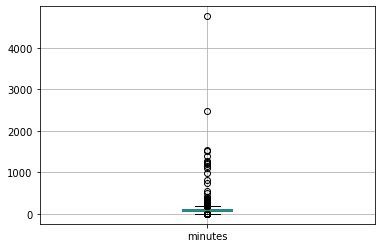

In [24]:
df.boxplot('minutes')
df = detecting_outliers_numerical(df, 'minutes', 0, 600, 'median')

(array([5.7790e+03, 5.1006e+04, 2.1965e+04, 2.2740e+03, 2.5200e+02,
        3.4000e+01, 6.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.93833333, 1.87666667, 2.815     , 3.75333333,
        4.69166667, 5.63      , 6.56833333, 7.50666667, 8.445     ,
        9.38333333]),
 <BarContainer object of 10 artists>)

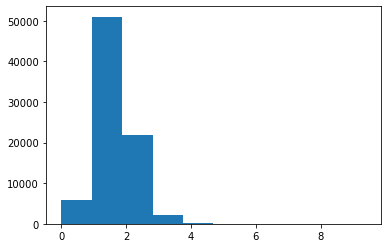

In [25]:
plt.hist(df['minutes']/60)

In [26]:
print_stat(df, 'minutes') #104430

# in the already seen graph, the majority of the matches has happened within 1 hour, even if we show the difference between the mean and median
# we decide to apply the amount of time of 60.00 minutes for the unknown values since it is the one with the better similar standard deviation 

var = df[['minutes']].copy()
var['minutes'].fillna(var.minutes.mean(), inplace = True)
print_stat(var, 'minutes')

var2 = df[['minutes']].copy()
var2['minutes'].fillna(var2.minutes.median(), inplace = True)
print_stat(var2, 'minutes')

var3 = df[['minutes']].copy()
var3['minutes'].fillna(60.00, inplace = True)
print_stat(var3, 'minutes') #0

df['minutes'] = var3['minutes'].copy()

minutes null_values:	104430
count    81320.000000
mean        97.448967
std         34.732848
min          0.000000
25%         72.000000
50%         91.000000
75%        119.000000
max        563.000000
Name: minutes, dtype: float64
minutes null_values:	0
count    185750.000000
mean         97.448967
std          22.981225
min           0.000000
25%          97.448967
50%          97.448967
75%          97.448967
max         563.000000
Name: minutes, dtype: float64
minutes null_values:	0
count    185750.000000
mean         93.823311
std          23.202868
min           0.000000
25%          91.000000
50%          91.000000
75%          91.000000
max         563.000000
Name: minutes, dtype: float64
minutes null_values:	0
count    185750.000000
mean         76.394886
std          29.551951
min           0.000000
25%          60.000000
50%          60.000000
75%          85.000000
max         563.000000
Name: minutes, dtype: float64


(array([5.77900e+03, 1.55436e+05, 2.19650e+04, 2.27400e+03, 2.52000e+02,
        3.40000e+01, 6.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.        , 0.93833333, 1.87666667, 2.815     , 3.75333333,
        4.69166667, 5.63      , 6.56833333, 7.50666667, 8.445     ,
        9.38333333]),
 <BarContainer object of 10 artists>)

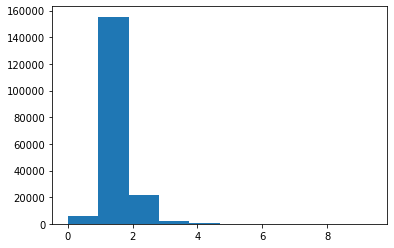

In [27]:
plt.hist(df['minutes']/60)

### surface
Choosing to change the missing values respecting the distribution is avoided since it could be done bringing errors. Keep them empty since the missing values are for matches that happened in different places where we cannot be sure of the surface value.


In [28]:
print_simple_stat(df, 'surface') 
# they are competitions that have happened in different places so is not possile to resolve their knowledge 
# the only way to resolve them is by using an external resource as Google
# for that reason we leave them as NaN

tourney_ids = df[ df['surface'].isnull() ]
tourney_ids = tourney_ids.groupby(tourney_ids.tourney_name).size()
tourney_ids = pd.DataFrame(tourney_ids)
tourney_ids.reset_index(level=0, inplace=True)
tourney_ids.rename( columns={ 0 :'freq'}, inplace = True)
print(tourney_ids[tourney_ids['freq']>=3])

surface null_values:	162
                   tourney_name  freq
0   Davis Cup G1 R1: ISR vs POR     4
1   Davis Cup G1 R1: NZL vs IND     4
2   Davis Cup G1 R1: PER vs ECU     4
3   Davis Cup G1 R1: ROU vs BLR     4
4   Davis Cup G1 R1: TPE vs CHN     4
5   Davis Cup G1 R1: UZB vs KOR     3
6   Davis Cup G1 R2: SVK vs HUN     3
7   Davis Cup G2 R1: BAH vs VEN     4
8   Davis Cup G2 R1: BAR vs PAR     4
9   Davis Cup G2 R1: BOL vs ESA     4
10  Davis Cup G2 R1: EST vs RSA     4
11  Davis Cup G2 R1: FIN vs GEO     4
12  Davis Cup G2 R1: INA vs PHI     4
13  Davis Cup G2 R1: KUW vs THA     3
14  Davis Cup G2 R1: LTU vs MAD     4
15  Davis Cup G2 R1: MAR vs DEN     4
16  Davis Cup G2 R1: MEX vs GUA     3
17  Davis Cup G2 R1: MON vs SLO     4
18  Davis Cup G2 R1: NOR vs LAT     4
19  Davis Cup G2 R1: TUR vs CYP     4
20  Davis Cup G2 R1: VIE vs HKG     4
23    Fed Cup G2 PM: DOM vs CRC     4


### gender
Only matches with same gender are assumed so, using this fact it's possible to deduce the gender of the missing player, such as, if we know the gender of the winner then we can also know the gender of the loser, and vice versa.

<AxesSubplot:title={'center':'Distribution of tourney_level values according to the gender of the player'}, xlabel='Gender of the winner and loser player', ylabel='Counting'>

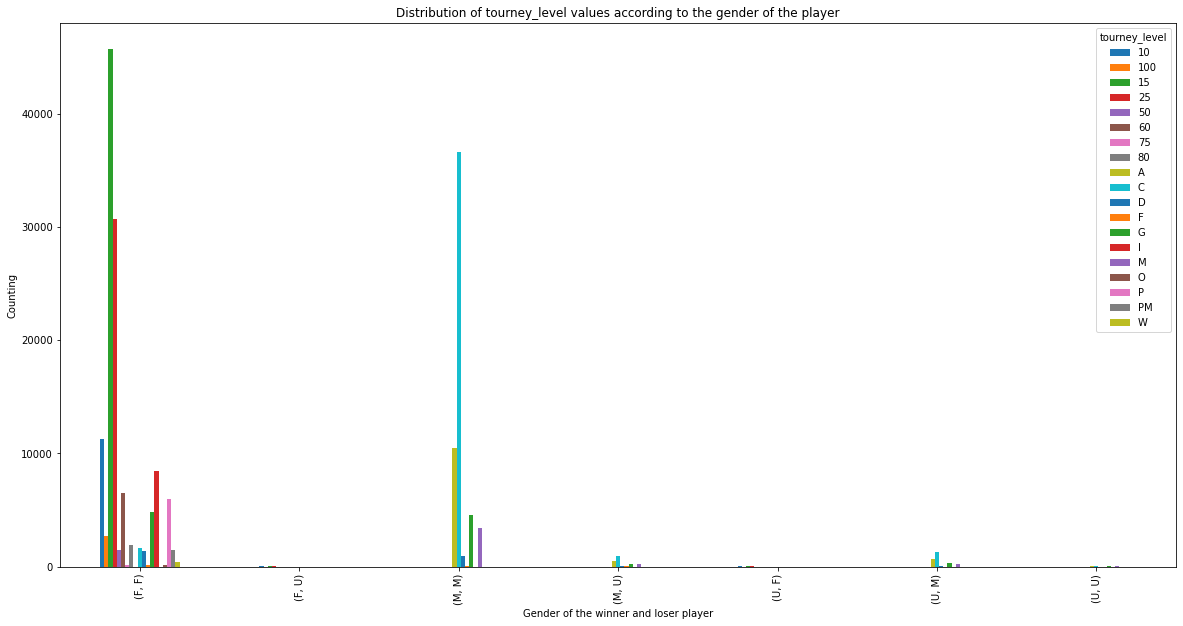

In [29]:
lf = df.groupby(['winner_gender', 'loser_gender', 'tourney_level']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of tourney_level values according to the gender of the player", 
    xlabel="Gender of the winner and loser player",
    ylabel="Counting",
    kind='bar')

In [30]:
var = df[ df['winner_gender'] == 'U']
var['loser_gender']=var['loser_gender'].replace({'U': np.nan}, regex=True)
var = var[var['loser_gender'].notna()]

var = var.groupby(['winner_name']).loser_gender.unique()

var = pd.DataFrame(var)
var.reset_index(level=0, inplace=True)

df[df.winner_name.isin(var['winner_name'])].winner_gender=df[df.winner_name.isin(var['winner_name'])].loser_gender.values
df[df.winner_name.isin(var['winner_name'])] = df[df.winner_name.isin(var['winner_name'])].assign(winner_gender=df[df.winner_name.isin(var['winner_name'])].loser_gender)


<ipython-input-30-a333d79c7317>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var['loser_gender']=var['loser_gender'].replace({'U': np.nan}, regex=True)
C:\Users\Gerlando\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
var = df[ df['loser_gender'] == 'U']
var['winner_gender']=var['winner_gender'].replace({'U': np.nan}, regex=True)
var = var[var['winner_gender'].notna()]

var = var.groupby(['loser_name']).winner_gender.unique()

var = pd.DataFrame(var)
var.reset_index(level=0, inplace=True)

df[df.loser_name.isin(var['loser_name'])].loser_gender=df[df.loser_name.isin(var['loser_name'])].winner_gender.values
df[df.loser_name.isin(var['loser_name'])] = df[df.loser_name.isin(var['loser_name'])].assign(loser_gender=df[df.loser_name.isin(var['loser_name'])].winner_gender)

<ipython-input-31-91b2aca6544e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var['winner_gender']=var['winner_gender'].replace({'U': np.nan}, regex=True)


###### tourney_level where both players have gender 'U' refer to matches among M genders. Only tourney_level D is for both gender, looking names, gender M are assigned to them.

<AxesSubplot:title={'center':'Distribution of tourney_level values according to the gender of the player'}, xlabel='Gender of the winner and loser player', ylabel='Counting'>

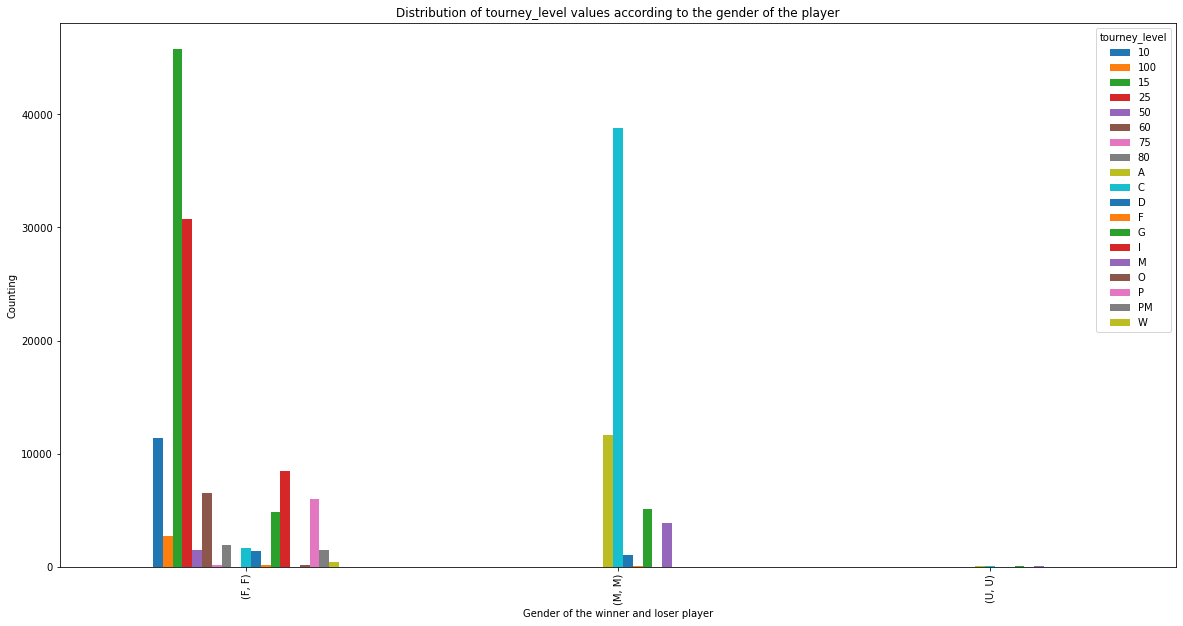

In [32]:
lf = df.groupby(['winner_gender', 'loser_gender', 'tourney_level']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of tourney_level values according to the gender of the player", 
    xlabel="Gender of the winner and loser player",
    ylabel="Counting",
    kind='bar')

In [33]:
gen = df[df['winner_gender'] == 'U']
gen.groupby('winner_gender').tourney_level.unique()

winner_gender
U    [A, M, G, D, C]
Name: tourney_level, dtype: object

In [34]:
tourney_lev_male = ['A', 'M', 'G', 'C']
for lev in tourney_lev_male:
    df.loc[(df['winner_gender'] == 'U') & (df['tourney_level'] == lev), 'winner_gender'] = 'M'
    df.loc[(df['loser_gender'] == 'U') & (df['tourney_level'] == lev), 'loser_gender'] = 'M'

In [35]:
df.loc[(df['winner_gender'] == 'U') & (df['tourney_level'] == 'D')] 

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue,winner_gender,loser_gender,SvGms
5801,2019-M-DC-2019-FLS-C-M-ARG-CHI-01,Davis Cup Finals RR: ARG vs CHI,Hard,4.0,D,2019-11-19,2.0,106043.0,Diego Schwartzman,R,170.0,ARG,27.0,106426.0,Cristian Garin,R,185.0,CHI,23.0,6-2 6-2,3.0,RR,73.0,5.0,2.0,48.0,38.0,27.0,5.0,1.0,3.0,1.0,2.0,56.0,36.0,17.0,7.0,4.0,10.0,14.0,2125.0,33.0,1297.0,424.0,81710.80,U,U,16.0
7897,2018-M-DC-2018-G1-AM-M-ARG-CHI-01,Davis Cup G1 R2: ARG vs CHI,Clay,4.0,D,2018-04-06,2.0,106043.0,Diego Schwartzman,R,170.0,ARG,25.0,106426.0,Cristian Garin,R,185.0,CHI,21.0,7-6(2) 6-7(2) 6-2,3.0,RR,162.0,3.0,6.0,112.0,63.0,42.0,24.0,2.0,6.0,2.0,8.0,108.0,58.0,37.0,26.0,6.0,12.0,15.0,2220.0,217.0,256.0,426.0,85412.09,U,U,34.0


In [36]:
df.loc[(df['winner_gender'] == 'U') & (df['tourney_level'] == 'D'), 'winner_gender'] = 'M'
df.loc[(df['loser_gender'] == 'U') & (df['tourney_level'] == 'D'), 'loser_gender'] = 'M'

<AxesSubplot:title={'center':'Distribution of tourney_level values according to the gender of the player'}, xlabel='Gender of the winner and loser player', ylabel='Counting'>

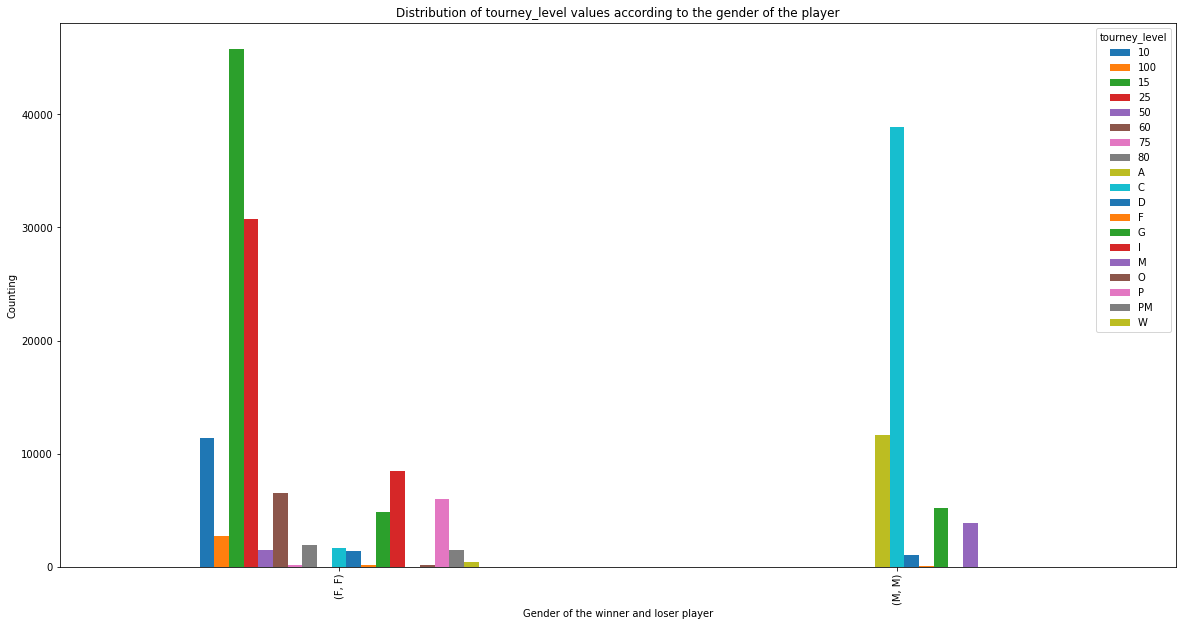

In [37]:
l= df.groupby(['winner_gender', 'loser_gender', 'tourney_level']).size()
l = l.unstack()
l.plot(
    figsize=(20, 10), 
    title="Distribution of tourney_level values according to the gender of the player", 
    xlabel="Gender of the winner and loser player",
    ylabel="Counting",
    kind='bar')

### heights
The heights are resolved in three steps:  
1. group by name and substitute missing values with heights mean of the player
2. group by gender and nationality together and resolve again with mean
3. group by only gender 

In [38]:
print_stat(df,'winner_ht')
df['winner_ht'] = df['winner_ht'].fillna(df.groupby('winner_name')['winner_ht'].transform('mean'))
print_stat(df, 'winner_ht')

print_stat(df, 'loser_ht')
df['loser_ht'] = df['loser_ht'].fillna(df.groupby('loser_name')['loser_ht'].transform('mean'))
print_stat(df, 'loser_ht')

winner_ht null_values:	136468
count    49282.000000
mean       181.415040
std         11.632295
min          2.000000
25%        175.000000
50%        183.000000
75%        188.000000
max        211.000000
Name: winner_ht, dtype: float64
winner_ht null_values:	134356
count    51394.000000
mean       180.978208
std         12.082347
min          2.000000
25%        175.000000
50%        182.000000
75%        188.000000
max        211.000000
Name: winner_ht, dtype: float64
loser_ht null_values:	147429
count    38321.000000
mean       181.567209
std         10.816284
min          2.000000
25%        175.000000
50%        183.000000
75%        188.000000
max        211.000000
Name: loser_ht, dtype: float64
loser_ht null_values:	145961
count    39789.000000
mean       181.159516
std         11.384144
min          2.000000
25%        175.000000
50%        183.000000
75%        188.000000
max        211.000000
Name: loser_ht, dtype: float64


In [39]:
#The remaining heights are estimated according to mean, grouping by nationality and gender together
w_ht = df[['winner_name', 'winner_ioc', 'winner_ht', 'winner_gender']].copy()
w_ht.set_axis(['name', 'ioc', 'ht', 'gender'], axis = 1, inplace = True)
l_ht = df[['loser_name','loser_ioc', 'loser_ht', 'loser_gender']].copy()
l_ht.set_axis(['name', 'ioc', 'ht', 'gender'], axis = 1, inplace = True)

player_ht = w_ht.append(l_ht)
player_ht.drop_duplicates(inplace = True)
#female players
female_ht = player_ht[player_ht.gender == 'F']
female_ht.ht.fillna(female_ht.groupby('ioc')['ht'].transform('mean'), inplace = True)
#for female not yet resolved, consider height's mean depending on only gender
female_ht.ht.fillna(female_ht.ht.mean(), inplace = True)

#male players
male_ht = player_ht[player_ht.gender == 'M']
male_ht.ht.fillna(male_ht.groupby('ioc')['ht'].transform('mean'), inplace = True)
male_ht.ht.fillna(male_ht.ht.mean(), inplace = True)


#when we'll create the player profile we are interested in the last ht 
player_ht = female_ht.append(male_ht)
player_ht = player_ht.groupby('name').ht.max()
player_ht = pd.DataFrame(player_ht)
player_ht = player_ht.reset_index()


#fillna winner player
player_ht.set_axis(['winner_name', 'winner_ht'], axis = 1, inplace = True)
del df['winner_ht']
df = pd.merge(df, player_ht, how = 'left', on = 'winner_name')


#fillna loser player
player_ht.set_axis(['loser_name', 'loser_ht'], axis = 1, inplace = True)
del df['loser_ht']
df = pd.merge(df, player_ht, how = 'left', on = 'loser_name')


print('rows with winner ht Nan', df.winner_ht.isna().sum())
print('rows with loser ht Nan', df.loser_ht.isna().sum())

C:\Users\Gerlando\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


rows with winner ht Nan 0
rows with loser ht Nan 0


In [40]:
player_ht.isna().sum()

loser_name    0
loser_ht      0
dtype: int64

### age
To avoid more values for same player, calulate birth year and substitute the attribute age with attribute birth, for both winner and loser player. It is computed by the difference between the tourney’s year, in which the match has been played, and the age of the player. In the case there are 2 different ages we took the minimum since the other has been changed due to the day of the birth.

In [41]:
df['tourney_date'] = pd.to_datetime(df['tourney_date'])
df['tourney_year'] = df['tourney_date'].dt.year
df['winner_birth']=df['tourney_year']-df['winner_age']
df['loser_birth']=df['tourney_year']-df['loser_age']

#winner_bith
winner_birth=df.groupby(['winner_name']).winner_birth.min() 
winner_birth = pd.DataFrame(winner_birth)
winner_birth.reset_index(inplace=True)
winner_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#loser_birth
loser_birth = df.groupby(['loser_name']).loser_birth.min() 
loser_birth = pd.DataFrame(loser_birth)
loser_birth.reset_index(inplace=True)
loser_birth.set_axis(['name', 'birth'], axis=1, inplace=True)

#players_birth
name_birth = winner_birth.append(loser_birth)
name_birth.dropna(inplace=True)
name_birth.drop_duplicates(inplace=True)
name_birth = name_birth.groupby(name_birth['name']).birth.min()
name_birth = pd.DataFrame(name_birth)
name_birth.reset_index(inplace=True)

del df['winner_birth']
del df['loser_birth']

#set winner birth
name_birth.set_axis(['winner_name', 'winner_birth'], axis=1, inplace=True)
df = pd.merge(df, name_birth, how='left', on='winner_name')
#set loser birth
name_birth.set_axis(['loser_name', 'loser_birth'], axis=1, inplace=True)
df = pd.merge(df, name_birth, how='left', on='loser_name')

In [42]:
del df['winner_age']
del df['loser_age']

In [43]:
print_simple_stat(df, 'winner_birth')
print_simple_stat(df, 'loser_birth')

winner_birth null_values:	2809
loser_birth null_values:	6468


In [44]:
#the commented number are NaN values before resolving some of them 
print_simple_stat(df, 'w_2ndWon') #103819
print_simple_stat(df, 'l_2ndWon') #103816 
print_simple_stat(df, 'winner_rank') #19372
print_simple_stat(df, 'loser_rank') #35232
print_simple_stat(df, 'winner_rank_points') #19388
print_simple_stat(df, 'loser_rank_points') #35248

w_2ndWon null_values:	55142
l_2ndWon null_values:	56825
winner_rank null_values:	19372
loser_rank null_values:	35231
winner_rank_points null_values:	19388
loser_rank_points null_values:	35247


## Wrong values

### tourney_name

Try to resolve wrong values in tourney name. Strings are normalized so extra special characters and punctuation are romoved, then tourney names are grouped by tourney id, this is useful to discover very similar names that have only few different characters, also names write in different ways or language are discovered and resolved.

In [45]:
df['tourney_name']=df['tourney_name'].str.upper()
dd = df.copy()
df['tourney_id']= df['tourney_id'].str[5:]
df['tourney_name']=df['tourney_name'].replace( {
    'MASTERS':'',
    ' \d*' : ' ',
    '[-._''+]' : ' ',
     "'": '',
    ' $ ' : '',
    'CH ':'',
    ' CH':'',        
    'SAN ':'ST.',
    'SAINT ':'ST.',
    'ST. ':'ST '
}, regex=True)

TourneyId_name = df.groupby(['tourney_id']).tourney_name.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
TourneyId_name = TourneyId_name[TourneyId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value


print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique())
print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique().count())

tourney_id
0405              [TOKYO , JAPAN OPEN TOKYO, HIROSHIMA]
0637                      [CHAMPAIGN, CHAMPAIGN URBANA]
0703                                [STANFORD, ST.JOSE]
0741                           [EASTBOURNE, NOTTINGHAM]
0784                                 [SEVILLE, SEVILLA]
0806                      [TORONTO, MONTREAL, TORONTO ]
0808                       [SINGAPORE, SHENZHEN FINALS]
0891                                    [PUNE, CHENNAI]
1056                                     [TOKYO, OSAKA]
1091                                 [CALVIA, MALLORCA]
1094                                 [GSTAAD, LAUSANNE]
1096                                  [TAIPEI, HUA HIN]
1796                             [ST BRIEUC, ST.BRIEUC]
2000                                [CHICAGO, CHICAGO ]
2151                                      [ROME, ROME ]
3618                  [ASTANA, NUR SULTAN, NUR SULTAN ]
3627                                    [TODI, LAQUILA]
3945            [ST.BENEDETTO DEL TRO

In [46]:

df['tourney_name']=df['tourney_name'].replace( {
    'SEVILLA':'SEVILLE',
    'ST BRIEUC':'ST.BRIEUC',
    'ST.BENEDETTO':'ST.BENEDETTO DEL TRONTO',
    'HOI MINH CITY':'HOI MINH',
    'LISBOA':'LISBON',
    'BENGALURU':'BANGALORE',
    'POPRAD TATRY':'POPRAD',
}, regex=True)

df['tourney_name']=df['tourney_name'].replace( {
    'DEL TRONTO DEL TRONTO':'DEL TRONTO',
    'RIO RIO ':'RIO ',
}, regex=True)


df['tourney_name'] = df['tourney_name'].str.rstrip()


TourneyId_name = df.groupby(['tourney_id']).tourney_name.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
TourneyId_name = TourneyId_name[TourneyId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique())
print(df[df.tourney_id.isin(TourneyId_name.index)].groupby(['tourney_id']).tourney_name.unique().count())
df['tourney_id']=dd['tourney_id']


tourney_id
0405               [TOKYO, JAPAN OPEN TOKYO, HIROSHIMA]
0637                      [CHAMPAIGN, CHAMPAIGN URBANA]
0703                                [STANFORD, ST.JOSE]
0741                           [EASTBOURNE, NOTTINGHAM]
0806                                [TORONTO, MONTREAL]
0808                       [SINGAPORE, SHENZHEN FINALS]
0891                                    [PUNE, CHENNAI]
1056                                     [TOKYO, OSAKA]
1091                                 [CALVIA, MALLORCA]
1094                                 [GSTAAD, LAUSANNE]
1096                                  [TAIPEI, HUA HIN]
3618                               [ASTANA, NUR SULTAN]
3627                                    [TODI, LAQUILA]
5016                       [BUCARAMANGA, FLORIDABLANCA]
5069                              [SARASOTA, BRADENTON]
581     [DOHA AUS OPEN QUALIES, DUBAI AUS OPEN QUALIES]
6963                              [MORELOS, CUERNAVACA]
7318                              [CO

### winner_name and loser_name
Verify if there is a unique relationship between ids and names. Unfortunately a name is not identified by a unique id and to a id corresponds more than one names. So no correction is applied.

In [47]:
df['winner_name']=df['winner_name'].str.upper()
df['winner_name']=df['winner_name'].replace({'  ':' '}, regex=True)
WinnerId_name = df.groupby(['winner_name']).winner_id.nunique()
WinnerId_name = WinnerId_name[WinnerId_name > 1] 
print('winners with more than one id:',df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_id.unique().count())

winners with more than one id: 9


In [48]:
df['loser_name']=df['loser_name'].str.upper()
df['loser_name']=df['loser_name'].replace({'  ':' '}, regex=True)
LoserId_name = df.groupby(['loser_name']).loser_id.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 
print('winners with more than one id:',df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_id.unique())

winners with more than one id: loser_name
ASTRID CIROTTE             [223401.0, 236980.0]
EKATERINA MAKAROVA         [201505.0, 223126.0]
ELENI FASOULA              [222942.0, 222943.0]
ELLIE MYERS                [222407.0, 240168.0]
EMILSE LUJAN RUIZ          [222646.0, 236974.0]
FITRIANI SABATINI          [221189.0, 239429.0]
GIUSEPPE TRESCA            [206834.0, 207982.0]
GUY STOKMAN                [206883.0, 207142.0]
HEI CHING CLAUDIA NG       [219835.0, 216586.0]
HOLLY FISCHER              [221142.0, 222228.0]
KUAN YI LEE                [134120.0, 221745.0]
LARA ONAL                  [224486.0, 223215.0]
LIISA VARUL                [222915.0, 222914.0]
MARIA FERNANDA NAVARRO     [223367.0, 223287.0]
MATYLDA BURYLO             [222845.0, 222066.0]
NANA KAWAGISHI             [221771.0, 244078.0]
SOFIA NAHIARA GARCIA       [220928.0, 236977.0]
STANISLAVA BOBROVNIKOVA    [221347.0, 225865.0]
VALENTINA LIA              [220334.0, 239415.0]
Name: loser_id, dtype: object


In [49]:
LoserId_name = df.groupby(['loser_id']).loser_name.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 
print("HOW MANY IDs CORRESPOND TO MORE THAN ONE NAMES:", df[df.loser_id.isin(LoserId_name.index)].groupby(['loser_id']).loser_name.unique().count())
print(df[df.loser_id.isin(LoserId_name.index)].groupby(['loser_id']).loser_name.unique())

HOW MANY IDs CORRESPOND TO MORE THAN ONE NAMES: 47
loser_id
200033.0                      [SERENA WILLIAMS, KUSHAAN NATH]
202273.0                    [ANURAG NENWANI, LIGA DEKMEIJERE]
202277.0                      [MARIANA CORREA, DAMIEN WENGER]
202349.0                   [RUSHMI CHAKRAVARTHI, KAI LEMSTRA]
202359.0                      [MARVIN MOELLER, CHIN WEI CHAN]
202414.0             [CATHERINE HARRISON, ALEXANDRE ROTSAERT]
202419.0                     [BARBARA LUZ, JUSTIN SCHLAGETER]
202420.0                    [AIDAN MCHUGH, AN SOPHIE MESTACH]
202421.0               [ALISON VAN UYTVANCK, GEORGE HOUGHTON]
202426.0                         [JULIA BOSERUP, MATT HALPIN]
202428.0                 [KIKI BERTENS, JOAO PEDRO ALCANTARA]
202429.0                [CAMILA GIORGI, DAVID LUCAS AMBROZIC]
202432.0                    [HILDA MELANDER, NICK STACHOWIAK]
202433.0                [ANNA GIULIA REMONDINA, CONG TIEN LE]
202434.0                   [ALEKSANDRA KRUNIC, RICARDO ORTIZ]
202436.0  

### winner_ioc
Regarding the nationalities, use a pycountry library in order to check if the code of each nation is written correctly, the analysis gives good results for all the attributes. Is noted that some players (3 to be precise) appear with multiple nationalities, following research with external sources it is checked which players have dual nationality and replace those which have the wrong nationalities with the correct ones. 

In [50]:
country_winner_dim=df.groupby(df.winner_ioc,as_index=False).size()
nation=np.concatenate((df.winner_ioc.unique(), df.loser_ioc.unique()),0)
country = pd.DataFrame(nation)
country = country.drop_duplicates()

no=0

for i in country[0]:
    try:
        pycountry.countries.get(alpha_3=i)
    except:
        no+=1
        
print("no:",no)



no: 0


In [51]:
LoserId_name = df.groupby(['loser_name']).loser_ioc.nunique()
LoserId_name = LoserId_name[LoserId_name > 1] 
df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_ioc.unique()

loser_name
ANASTASIA KULIKOVA    [RUS, FIN]
ELENI FASOULA         [GRE, KAZ]
MATYLDA BURYLO        [POL, NOR]
Name: loser_ioc, dtype: object

In [52]:
print(df[df.winner_name=='ELENI FASOULA']['winner_ioc'].unique())
print(df[df.loser_name=='ELENI FASOULA']['loser_ioc'].unique())

df.loc[(df.winner_name=='ELENI FASOULA'), 'winner_ioc'] = 'GRE' 
df.loc[(df.loser_name=='ELENI FASOULA'), 'loser_ioc'] = 'GRE' 

print(df[df.winner_name=='ELENI FASOULA']['winner_ioc'].unique())
print(df[df.loser_name=='ELENI FASOULA']['loser_ioc'].unique())

print(df[df.winner_name=='MATYLDA BURYLO']['winner_ioc'].unique())
print(df[df.loser_name=='MATYLDA BURYLO']['loser_ioc'].unique())

df.loc[(df.winner_name=='MATYLDA BURYLO'), 'winner_ioc'] = 'NOR' 
df.loc[(df.loser_name=='MATYLDA BURYLO'), 'loser_ioc'] = 'NOR' 

print(df[df.winner_name=='MATYLDA BURYLO']['winner_ioc'].unique())
print(df[df.loser_name=='MATYLDA BURYLO']['loser_ioc'].unique())

df.loc[(df.winner_name=='ANASTASIA KULIKOVA'), 'winner_ioc'] = '[RUS, FIN]' 
df.loc[(df.loser_name=='ANASTASIA KULIKOVA'), 'loser_ioc'] = '[RUS, FIN]' 

print(df[df.winner_name=='ANASTASIA KULIKOVA']['winner_ioc'].unique())
print(df[df.loser_name=='ANASTASIA KULIKOVA']['loser_ioc'].unique())

['KAZ']
['GRE' 'KAZ']
['GRE']
['GRE']
[]
['POL' 'NOR']
[]
['NOR']
['[RUS, FIN]']
['[RUS, FIN]']


In [53]:
LoserId_name = df.groupby(['winner_name']).winner_ioc.nunique() # it contains each value of TourneyId and the number of Tourneyname values it is associated with 
LoserId_name = LoserId_name[LoserId_name > 1] # it contains the TourneyId values associated with more than one Tourneyname value

df[df.winner_name.isin(LoserId_name.index)].groupby(['winner_name']).winner_ioc.unique()

Series([], Name: winner_ioc, dtype: object)

#### winner_hand and loser_hand
Try to resolve player with more than one hand assigned to him. Search for players with 'U' hand and 'R' or 'L' hand and substitute U hand with the correct one.

In [54]:
LoserId_name = df.groupby(['loser_name']).loser_hand.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_hand.unique()
names=df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_hand.unique()

for i in names.keys():
    value=df[(df.loser_name==i) & (df.loser_hand!='U')]['loser_hand'].unique()
    df.loc[(df.loser_name==i) & (df.loser_hand=='U'), 'loser_hand'] = value[0]

WinnerId_name = df.groupby(['winner_name']).winner_hand.nunique() 
WinnerId_name = WinnerId_name[WinnerId_name > 1] 

df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_hand.unique()
names=df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_hand.unique()

for i in names.keys():
    value=df[(df.winner_name==i) & (df.winner_hand!='U')]['winner_hand'].unique()
    df.loc[(df.winner_name==i) & (df.winner_hand=='U'), 'winner_hand']=value[0]

## winner_gender and loser_gender
Player with more genders are resolved assign only one.

In [55]:
LoserId_name = df.groupby(['loser_name']).loser_gender.nunique() 
LoserId_name = LoserId_name[LoserId_name > 1] 

df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_gender.unique()
names=df[df.loser_name.isin(LoserId_name.index)].groupby(['loser_name']).loser_gender.unique()
for i in names.keys():
    value=df[(df.loser_name==i) & (df.loser_gender!='U')]['loser_gender'].unique()
    df.loc[(df.loser_name==i), 'loser_gender'] = value[0]

WinnerId_name = df.groupby(['winner_name']).winner_gender.nunique() 
WinnerId_name = WinnerId_name[WinnerId_name > 1] 

df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_gender.unique()
names=df[df.winner_name.isin(WinnerId_name.index)].groupby(['winner_name']).winner_gender.unique()

for i in names.keys():
    value=df[(df.winner_name==i) & (df.winner_gender!='U')]['winner_gender'].unique()
    df.loc[(df.winner_name==i), 'winner_gender'] = value[0]

# Outliers
Try to discover outliers in each numerical attribute considering, if necessary, more attributes together, in case some constraints are present.

#### winner and loser ht

Use the boxplot to visualize if there are some outliers inside attributes. Because players with an outlier heigth are very few, external sources are used to find the correct values of this attribute. Not all values are outliers, some of them are the real value of corresponding attribute.
The only wrong value are:
Ilija Vucic:       145 --> 188
Kamilla Rakhimova: 2.0 --> 174
Ivo Karlovic:      208 --> 211

<AxesSubplot:>

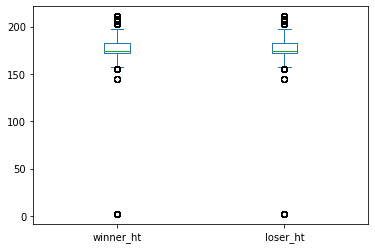

In [56]:
df_box = df[['winner_ht', 'loser_ht']].copy()
df_box.plot.box()

In [57]:
L, R = detecting_outliers(df.winner_ht)
df_outliers = df[(df.winner_ht < L) | (df.winner_ht > R)]
print("print winner with possibly wrong ht\n", df_outliers.groupby(['winner_name']).winner_ht.unique())

print winner with possibly wrong ht
 winner_name
ALBANO OLIVETTI      [203.0]
ILIJA VUCIC          [145.0]
IVO KARLOVIC         [208.0]
JERZY JANOWICZ       [203.0]
JOHN ISNER           [206.0]
KAMILLA RAKHIMOVA      [2.0]
KENNY DE SCHEPPER    [203.0]
KEVIN ANDERSON       [203.0]
KURUMI NARA          [155.0]
REILLY OPELKA        [211.0]
Name: winner_ht, dtype: object


In [58]:
df.loc[df['winner_name'] == 'KAMILLA RAKHIMOVA', 'winner_ht'] = 174.0 
df.loc[df['winner_name'] == 'ILIJA VUCIC', 'winner_ht'] = 188.0 
df.loc[df['winner_name'] == 'IVO KARLOVIC', 'winner_ht'] = 211.0 

The same thing is done for losers

In [59]:
L, R = detecting_outliers(df.loser_ht)
df_outliers = df[(df.loser_ht < L) | (df.loser_ht > R)]
print("print loser with possibly wrong ht\n", df_outliers.groupby(['loser_name']).loser_ht.unique())

print loser with possibly wrong ht
 loser_name
ALBANO OLIVETTI      [203.0]
ILIJA VUCIC          [145.0]
IVO KARLOVIC         [208.0]
JERZY JANOWICZ       [203.0]
JOHN ISNER           [206.0]
KAMILLA RAKHIMOVA      [2.0]
KENNY DE SCHEPPER    [203.0]
KEVIN ANDERSON       [203.0]
KURUMI NARA          [155.0]
MARCELO MELO         [203.0]
REILLY OPELKA        [211.0]
Name: loser_ht, dtype: object


In [60]:
df.loc[df['loser_name'] == 'KAMILLA RAKHIMOVA', 'loser_ht'] = 174 
df.loc[df['loser_name'] == 'ILIJA VUCIC', 'loser_ht'] = 188 
df.loc[df['loser_name'] == 'IVO KARLOVIC', 'loser_ht'] = 211 

<AxesSubplot:>

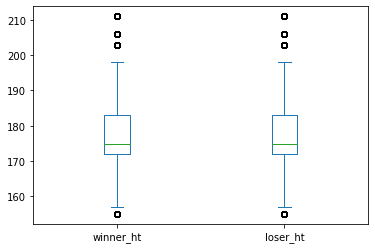

In [61]:
df_box = df[['winner_ht', 'loser_ht']].copy()
df_box.plot.box()

#### winner_birth and loser_birth
the birth year of players born before 1960 is changed with L

<AxesSubplot:>

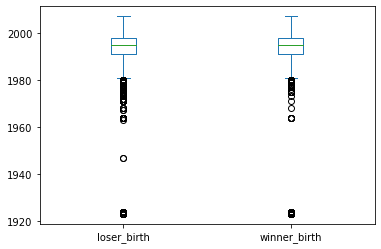

In [62]:
df_box = df[['loser_birth', 'winner_birth']].copy()
df_box.plot.box()

In [63]:
L, R = detecting_outliers(df.winner_birth)
df.loc[df['winner_birth'] < 1960, 'winner_birth'] = L
df.loc[df['loser_birth'] < 1960, 'loser_birth'] = L

<AxesSubplot:>

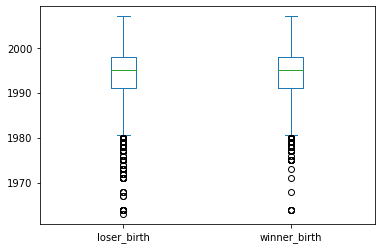

In [64]:
df_box = df[['loser_birth', 'winner_birth']].copy()
df_box.plot.box()

#### winner_rank , loser_rank  | winner_rank_point, loser_rank_point
Since rank and rank points are very sparse because each player has a different rank, could be useful analyze the trend of hyperbole looked before. It's possibile to observe that no one point is out of this trend, so no one outlier is present.

<AxesSubplot:>

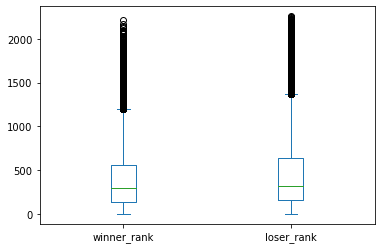

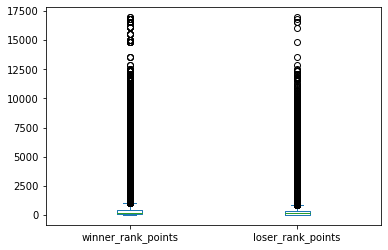

In [65]:
df_box = df[['winner_rank', 'loser_rank']].copy()
df_box.plot.box()
df_box = df[['winner_rank_points', 'loser_rank_points']].copy()
df_box.plot.box()

Text(0, 0.5, 'loser_rank_points')

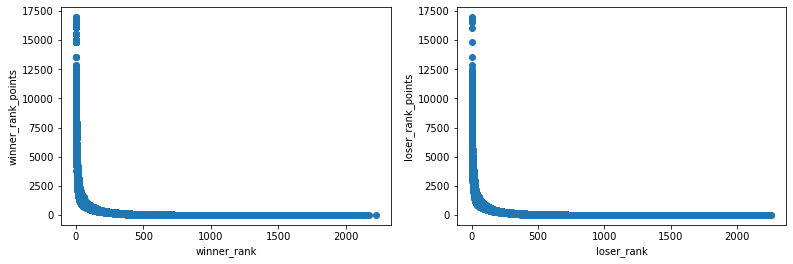

In [66]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))

axs[0].scatter(df['winner_rank'],df['winner_rank_points'])
axs[0].set_xlabel('winner_rank')
axs[0].set_ylabel('winner_rank_points')
axs[1].scatter(df['loser_rank'],df['loser_rank_points'])
axs[1].set_xlabel('loser_rank')
axs[1].set_ylabel('loser_rank_points')

#### w_ace and l_ace
Boxplots are not useful because values are too sparse.

<AxesSubplot:>

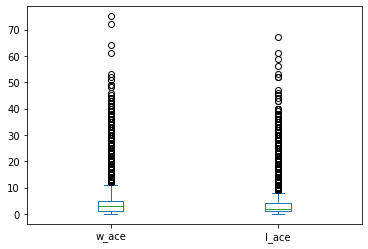

In [67]:
df_box = df[['w_ace', 'l_ace']].copy()
df_box.plot.box()

### ace with svpt
the trend of ace are studied with svpt because it is expected that the number of aces increase with respect the number of services. Looking to the trend, some points are very distant so, a threashold is set for both ace and svpt. Outliers are changed with the corresponding R value.

Text(0, 0.5, 'l_svpt')

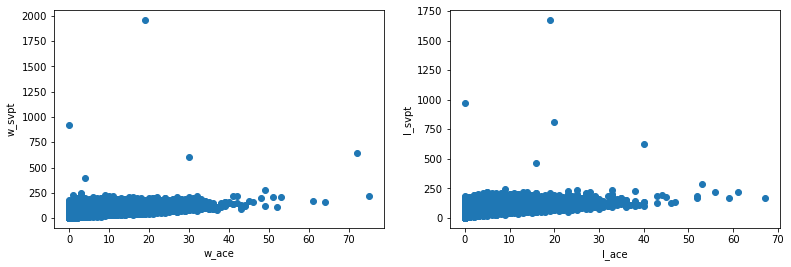

In [68]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_ace'],df['w_svpt'])
axs[0].set_xlabel('w_ace')
axs[0].set_ylabel('w_svpt')
axs[1].scatter(df['l_ace'],df['l_svpt'])
axs[1].set_xlabel('l_ace')
axs[1].set_ylabel('l_svpt')

In [69]:
L_ace,R_ace = detecting_outliers(df.w_ace)
L_svpt,R_svpt = detecting_outliers(df.w_svpt)
df.loc[df['w_ace'] >= 60, 'w_ace'] = R_ace
df.loc[df['w_svpt'] >= 300, 'w_svpt'] = R_svpt
L_ace, R_ace = detecting_outliers(df.l_ace)
L_svpt, R_svpt = detecting_outliers(df.l_svpt)
df.loc[df['l_ace'] >= 60, 'l_ace'] = R_ace
df.loc[df['l_svpt'] >= 300, 'l_svpt'] = R_svpt

Text(0, 0.5, 'l_svpt')

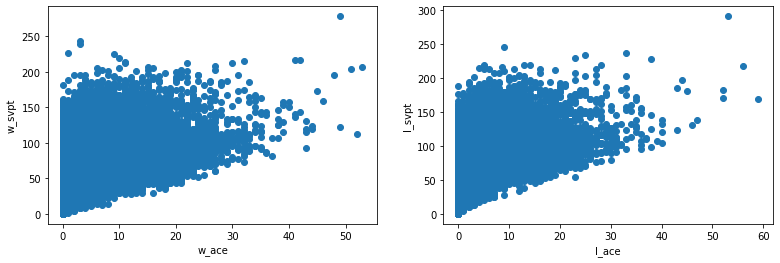

In [70]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_ace'],df['w_svpt'])
axs[0].set_xlabel('w_ace')
axs[0].set_ylabel('w_svpt')
axs[1].scatter(df['l_ace'],df['l_svpt'])
axs[1].set_xlabel('l_ace')
axs[1].set_ylabel('l_svpt')

#### w_df and l_df
Some points are far away from the distribution, so their values are changed with R.

<AxesSubplot:>

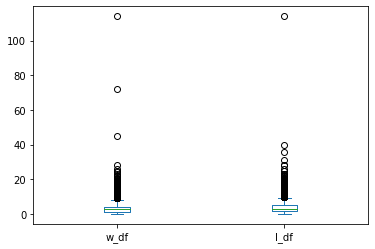

In [71]:
df_box = df[['w_df', 'l_df']].copy()
df_box.plot.box()

In [72]:
L, R = detecting_outliers(df.w_df)
df.loc[df['w_df'] >= 40, 'w_df'] = R
L, R = detecting_outliers(df.l_df)
df.loc[df['l_df'] >= 40, 'l_df'] = R

<AxesSubplot:>

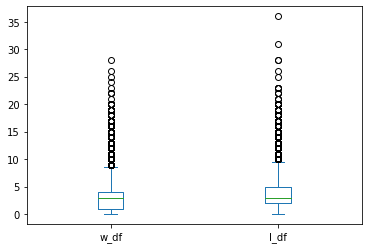

In [73]:
df_box = df[['w_df', 'l_df']].copy()
df_box.plot.box()

#### w_1stIn and l_1stIn
Looking to trend of 1_stIn respect to svpt, some points are far away from the distribution, so 1_stIn outliers are changed with R value.

Text(0, 0.5, 'l_1stIn')

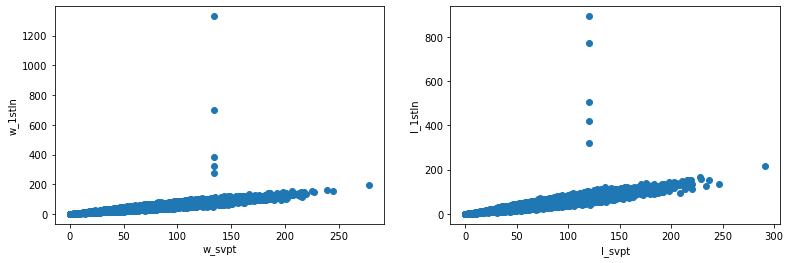

In [74]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_svpt'],df['w_1stIn'])
axs[0].set_xlabel('w_svpt')
axs[0].set_ylabel('w_1stIn')
axs[1].scatter(df['l_svpt'],df['l_1stIn'])
axs[1].set_xlabel('l_svpt')
axs[1].set_ylabel('l_1stIn')

In [75]:
L, R = detecting_outliers(df.w_1stIn)
df.loc[df['w_1stIn'] > df['w_svpt'], 'w_1stIn'] = R
L, R = detecting_outliers(df.l_1stIn)
df.loc[df['l_1stIn'] > df['l_svpt'], 'l_1stIn'] = R

Text(0, 0.5, 'l_svpt')

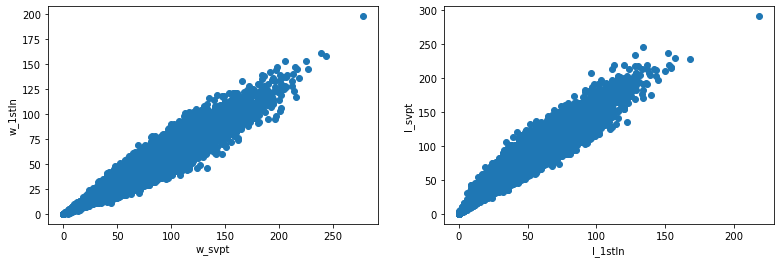

In [76]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_svpt'],df['w_1stIn'])
axs[0].set_xlabel('w_svpt')
axs[0].set_ylabel('w_1stIn')
axs[1].scatter(df['l_1stIn'],df['l_svpt'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_svpt')

#### w_1stWon l_1stWon 
Looking to trend of 1_stWon respect to 1_stIn, some points are far away from the distribution. Also values of 1_stWon must be less than the corresponding 1_stIn because it's impossible that the number of first serve points won is greater than first serve point made, so values of 1_stWon that are in contrast with it are changed with a propotion. This is made taking into account the total number of 1_stWon with respect to total number of 1_1stIn.

<AxesSubplot:>

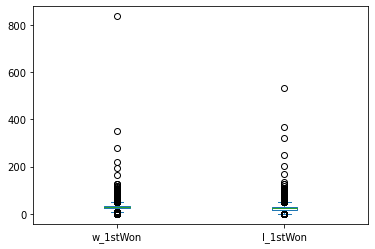

In [77]:
df_box = df[['w_1stWon', 'l_1stWon']].copy()
df_box.plot.box()

Text(0, 0.5, 'l_1stWon')

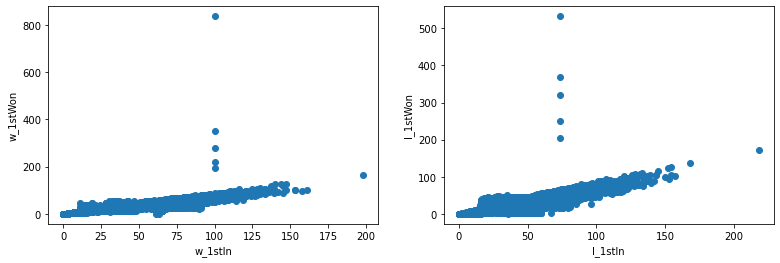

In [78]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_1stWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_1stWon')
axs[1].scatter(df['l_1stIn'],df['l_1stWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_1stWon')

In [79]:
L, R = detecting_outliers(df.w_1stWon)
df.loc[df['w_1stWon'] > df['w_1stIn'], 'w_1stWon'] = R
L, R = detecting_outliers(df.w_1stWon)
df.loc[df['l_1stWon'] > df['l_1stIn'], 'l_1stWon'] = R

Text(0, 0.5, 'l_1stWon')

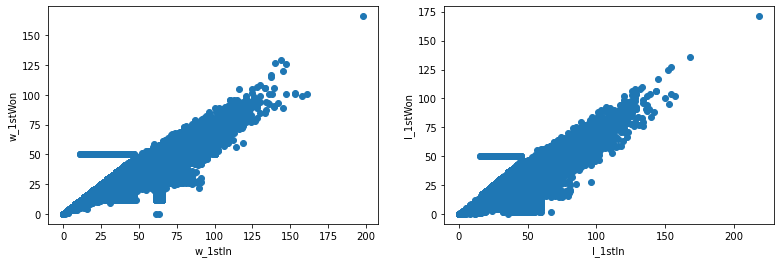

In [80]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_1stWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_1stWon')
axs[1].scatter(df['l_1stIn'],df['l_1stWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_1stWon')

In [81]:
rap_sum = (df['w_1stWon'].sum()) / (df['w_1stIn'].sum())
#w_1_stwon : w_1_stIn = w_1stWon_tot : w_1stIn_tot
df.loc[df['w_1stWon'] > df['w_1stIn'], 'w_1stWon'] = rap_sum*df.loc[df['w_1stWon'] > df['w_1stIn'],'w_1stIn']

rap_sum = (df['l_1stWon'].sum()) / (df['l_1stIn'].sum())
df.loc[df['l_1stWon'] > df['l_1stIn'], 'l_1stWon'] = rap_sum*df.loc[df['l_1stWon'] > df['l_1stIn'],'l_1stIn']

Text(0, 0.5, 'l_1stWon')

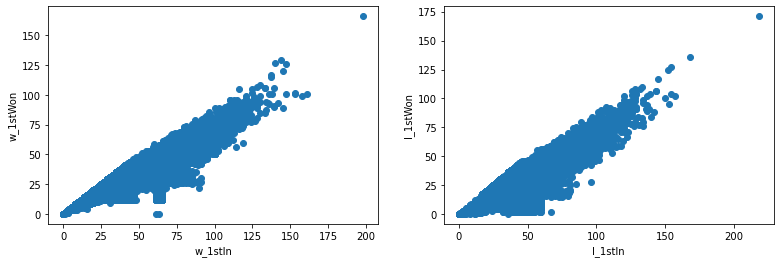

In [82]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_1stWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_1stWon')
axs[1].scatter(df['l_1stIn'],df['l_1stWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_1stWon')

#### w_2stWon l_2stWon  
The same analysis of 1_st1stWon is done.

Text(0, 0.5, 'l_2ndWon')

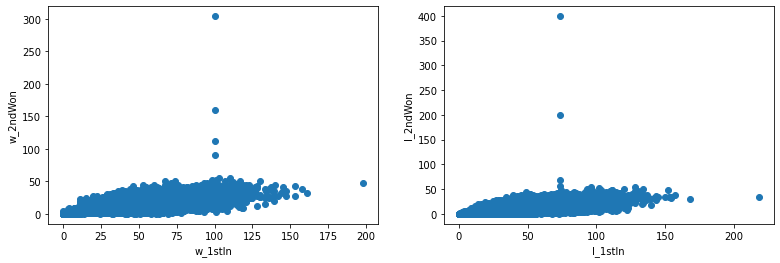

In [83]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_2ndWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_2ndWon')
axs[1].scatter(df['l_1stIn'],df['l_2ndWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_2ndWon')

In [84]:
L, R = detecting_outliers(df.w_2ndWon)
df.loc[df['w_2ndWon'] > df['w_1stIn'], 'w_2ndWon'] = R
L, R = detecting_outliers(df.w_2ndWon)
df.loc[df['l_2ndWon'] > df['l_1stIn'], 'l_2ndWon'] = R

Text(0, 0.5, 'l_2ndWon')

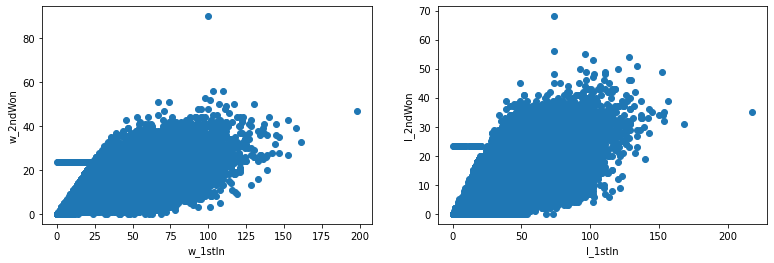

In [85]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_2ndWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_2ndWon')
axs[1].scatter(df['l_1stIn'],df['l_2ndWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_2ndWon')

In [86]:
rap_sum = (df['w_2ndWon'].sum()) / (df['w_1stIn'].sum())
#w_2ndWon : w_1_stIn = w_2ndWon_tot : w_1stIn_tot
df.loc[df['w_2ndWon'] > df['w_1stIn'], 'w_2ndWon'] = rap_sum*df.loc[df['w_2ndWon'] > df['w_1stIn'],'w_1stIn']

rap_sum = (df['l_2ndWon'].sum()) / (df['l_1stIn'].sum())
df.loc[df['l_2ndWon'] > df['l_1stIn'], 'l_2ndWon'] = rap_sum*df.loc[df['l_2ndWon'] > df['l_1stIn'],'l_1stIn']

Text(0, 0.5, 'l_2ndWon')

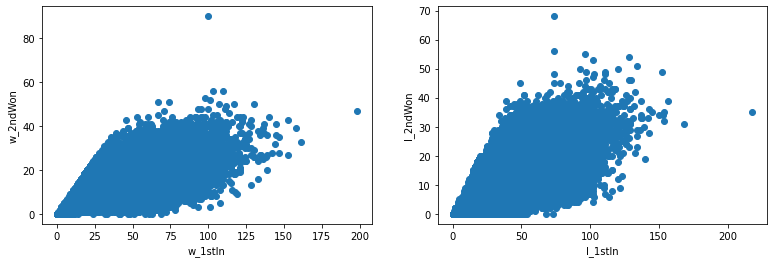

In [87]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_1stIn'],df['w_2ndWon'])
axs[0].set_xlabel('w_1stIn')
axs[0].set_ylabel('w_2ndWon')
axs[1].scatter(df['l_1stIn'],df['l_2ndWon'])
axs[1].set_xlabel('l_1stIn')
axs[1].set_ylabel('l_2ndWon')

<AxesSubplot:>

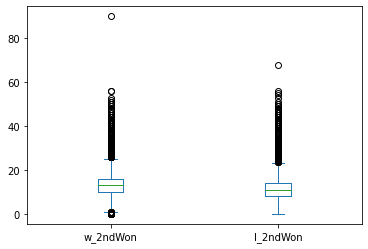

In [88]:
df_box = df[['w_2ndWon', 'l_2ndWon']].copy()
df_box.plot.box()

#### w_bpSaved w_bpFaced and l_bpSaved l_bpFaced
Firstly substitute value points that are far away from the distribution observed in box plot. After, since breakpoints saved and faced are strongly correlated, a linear trend is expected. Points that doesn't follow this trend are considered outliers.

<AxesSubplot:>

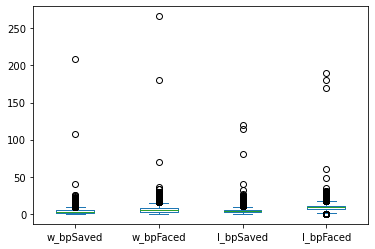

In [89]:
df_box = df[['w_bpSaved', 'w_bpFaced','l_bpSaved', 'l_bpFaced']].copy()
df_box.plot.box()

Text(0, 0.5, 'l_bpFaced')

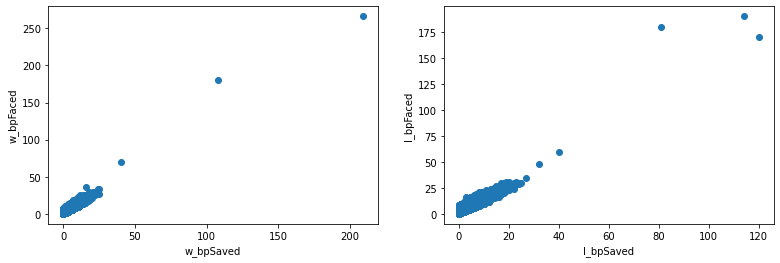

In [90]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_bpSaved'],df['w_bpFaced'])
axs[0].set_xlabel('w_bpSaved')
axs[0].set_ylabel('w_bpFaced')
axs[1].scatter(df['l_bpSaved'],df['l_bpFaced'])
axs[1].set_xlabel('l_bpSaved')
axs[1].set_ylabel('l_bpFaced')

In [91]:
L, R = detecting_outliers(df.w_bpSaved)
df.loc[df['w_bpSaved'] > 30, 'w_bpSaved'] = R
L, R = detecting_outliers(df.w_bpFaced)
df.loc[df['w_bpFaced'] > 30, 'w_bpFaced'] = R
L, R = detecting_outliers(df.l_bpSaved)
df.loc[df['l_bpSaved'] > 30, 'l_bpSaved'] = R
L, R = detecting_outliers(df.l_bpFaced)
df.loc[df['l_bpFaced'] > 30, 'l_bpFaced'] = R
df.loc[df['l_bpFaced'] < L, 'l_bpFaced'] = L

Text(0, 0.5, 'l_bpFaced')

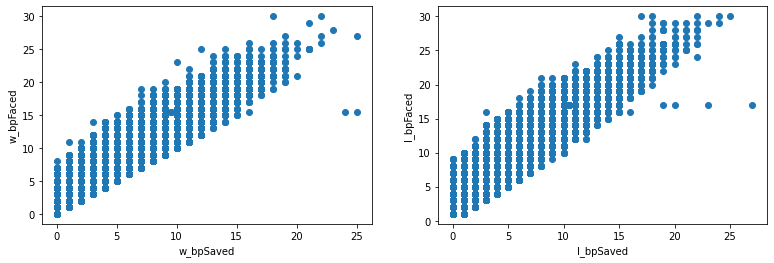

In [92]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(13,4))
axs[0].scatter(df['w_bpSaved'],df['w_bpFaced'])
axs[0].set_xlabel('w_bpSaved')
axs[0].set_ylabel('w_bpFaced')

axs[1].scatter(df['l_bpSaved'],df['l_bpFaced'])
axs[1].set_xlabel('l_bpSaved')
axs[1].set_ylabel('l_bpFaced')

<AxesSubplot:>

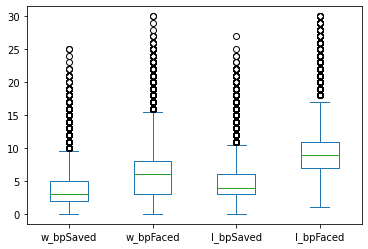

In [93]:
df_box = df[['w_bpSaved', 'w_bpFaced','l_bpSaved', 'l_bpFaced']].copy()
df_box.plot.box()

# Write on CSV

In [94]:
df.to_csv('dataset/matches_datacleaning.csv')